In [1]:
# Python 3.x
# pip install numpy scipy xarray matplotlib netcdf4

import numpy as np
import xarray as xr
from scipy.io import loadmat
import matplotlib.pyplot as plt
import sys
from pathlib import Path

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / '.git').exists():
            return p
    return start

here = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
repo_root = find_repo_root(here)
sys.path.append(str(repo_root / 'common' / 'python' / 'io'))
sys.path.append(str(repo_root / 'projects' / 'matlab2python' / 'shared' / 'python'))
sys.path.append(str(repo_root / 'common' / 'python' / 'plotting'))
sys.path.append('../util/shared/python/')

EASE_PATH = repo_root / 'common' / 'python' / 'plotting' / 'ease_grids'

from geospatial_plotting import plot_region, REGION_BOUNDS


In [2]:

# --------- 1) paths ---------
p_cntl = Path("/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/Evaluation/IVs/ASCL4_SMPL3_OLv8_M36_cd_TC_stats_201808_202405.mat")
p_da   = Path("/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/Evaluation/IVs/ASCL4_SMPL3_DAv8_M36_cd_TC_stats_201808_202405.mat")

# --------- 2) load .mat (squeeze to 1D vectors) ---------
def _vec(x):
    return np.asarray(x).squeeze()

M0 = loadmat(p_cntl, squeeze_me=True, struct_as_record=False)
M1 = loadmat(p_da,   squeeze_me=True, struct_as_record=False)

In [3]:

# expected vars: 'lons','lats','N_sm','Nmin','R2_TC_L3','R2_TC_ASC','R2_TC_mod',
# 'sigma2_L3','sigma2_mod','sigma2_ASC','R_mod_L3','R_mod_ASC','R_ASC_L3',
# 'C_L3_mod','C_mod_ASC','C_L3_ASC'

def _vec(x): return np.asarray(x).squeeze()

def grab(M, name):
    if name not in M:
        raise KeyError(f"Missing '{name}' in file")
    return _vec(M[name])

# --- grid shape from lons/lats ---
lons = grab(M0, "lons")
lats = grab(M0, "lats")

if lons.ndim == 2 and lats.ndim == 2:
    shp = lons.shape  # (nlon, nlat)
else:
    # If saved flat, set to your grid dims and reshape
    nlon, nlat = 406, 964
    shp = (nlon, nlat)
    lons = lons.reshape(shp)
    lats = lats.reshape(shp)

# Helpers to coerce arrays to 2D grid
def as_grid(M, key, shp):
    a = grab(M, key)
    if a.ndim == 2 and a.shape == shp:
        return a
    if a.size == np.prod(shp):
        return a.reshape(shp)
    # Some MATLAB saves may come as (nlat, nlon); handle simple transpose case
    if a.ndim == 2 and a.shape == (shp[1], shp[0]):
        return a.T
    raise ValueError(f"Field '{key}' has unexpected shape {a.shape}, cannot map to {shp}")

def get_fields(M, shp):
    grid_keys = [
        "N_sm",
        "R2_TC_L3","R2_TC_ASC","R2_TC_mod",
        "sigma2_L3","sigma2_mod","sigma2_ASC",
        "R_mod_L3","R_mod_ASC","R_ASC_L3",
        "C_L3_mod","C_mod_ASC","C_L3_ASC",
    ]
    out = {k: as_grid(M, k, shp) for k in grid_keys}
    # Scalars
    out["Nmin"] = float(grab(M, "Nmin"))
    return out

S0 = get_fields(M0, shp)  # CNTL
S1 = get_fields(M1, shp)  # CYG_DA


In [4]:

# --------- 3) build common-valid mask ---------
# same sampling threshold in both + all fields finite where needed
Nmin = int(np.nanmax(S0["Nmin"]))  # should be same value
Mvalid = (
    (S0["N_sm"] >= Nmin) & (S1["N_sm"] >= Nmin) &
    np.isfinite(S0["R2_TC_mod"]) & np.isfinite(S1["R2_TC_mod"]) &
    np.isfinite(S0["sigma2_mod"]) & np.isfinite(S1["sigma2_mod"])
)

# clamp any R2 slightly outside (0,1] due to rounding
def clamp01(a):
    out = a.copy()
    out[(out <= 0) | (~np.isfinite(out))] = np.nan
    out[out > 1] = 1.0
    return out

R2m0 = clamp01(S0["R2_TC_mod"])
R2m1 = clamp01(S1["R2_TC_mod"])


In [5]:

# --------- 4) compute metrics ---------
# (a) change in R^2 (positive is better)
dR2_mod = np.where(Mvalid, R2m1 - R2m0, np.nan)
pct_R2 = np.where(Mvalid, 100.0*(R2m1/R2m0 - 1), np.nan)  # positive % is better

def robust_sigma_t2(S, tol=1e-12, max_spread=50.0):
    C_l3m  = S["C_L3_mod"].astype(float)
    C_ma   = S["C_mod_ASC"].astype(float)
    C_l3a  = S["C_L3_ASC"].astype(float)

    # three TC permutations for σ_t^2
    s1 = (C_l3m * C_ma)  / C_l3a
    s2 = (C_l3m * C_l3a) / C_ma
    s3 = (C_ma  * C_l3a) / C_l3m
    stack = np.stack([s1, s2, s3], 0)

    # basic validity: finite and positive
    valid = np.isfinite(stack) & (stack > tol)
    sig_t2 = np.nanmedian(np.where(valid, stack, np.nan), axis=0)

    # consistency check: drop pixels where permutations disagree wildly
    smin = np.nanmin(np.where(valid, stack, np.nan), axis=0)
    smax = np.nanmax(np.where(valid, stack, np.nan), axis=0)
    spread = smax / smin
    bad = (~np.isfinite(sig_t2)) | (sig_t2 <= tol) | (~np.isfinite(spread)) | (spread > max_spread)
    sig_t2[bad] = np.nan
    return sig_t2

def direct_fMSE(S):
    """
    Compute fractional MSE directly from TC covariances & error variances.
    S must contain: 'sigma2_mod','sigma2_L3','sigma2_ASC',
                    'C_L3_mod','C_mod_ASC','C_L3_ASC'
    Returns: dict with fMSE_{mod,L3,ASC} and sigma_t2.
    """
    C_L3_mod = S["C_L3_mod"].astype(float)
    C_mod_ASC= S["C_mod_ASC"].astype(float)
    C_L3_ASC = S["C_L3_ASC"].astype(float)

    # Truth (signal) variance from TC geometry
    sigma_t2 = robust_sigma_t2(S)

    bad = (~np.isfinite(sigma_t2)) | (sigma_t2 <= 0)
    fMSE_mod = np.full_like(sigma_t2, np.nan)
    fMSE_L3  = np.full_like(sigma_t2, np.nan)
    fMSE_ASC = np.full_like(sigma_t2, np.nan)

    ok = ~bad
    # Require finite σ² as well
    ok_mod = ok & np.isfinite(S["sigma2_mod"])
    ok_L3  = ok & np.isfinite(S["sigma2_L3"])
    ok_ASC = ok & np.isfinite(S["sigma2_ASC"])

    fMSE_mod[ok_mod] = S["sigma2_mod"][ok_mod] / sigma_t2[ok_mod]
    fMSE_L3[ok_L3]   = S["sigma2_L3"][ok_L3]   / sigma_t2[ok_L3]
    fMSE_ASC[ok_ASC] = S["sigma2_ASC"][ok_ASC] / sigma_t2[ok_ASC]

    # Nonphysical negatives -> NaN
    fMSE_mod[fMSE_mod < 0] = np.nan
    fMSE_L3[fMSE_L3   < 0] = np.nan
    fMSE_ASC[fMSE_ASC < 0] = np.nan

    return dict(fMSE_mod=fMSE_mod, fMSE_L3=fMSE_L3, fMSE_ASC=fMSE_ASC, sigma_t2=sigma_t2)


def fMSE_from_R2(R2):
    fm = (1 - R2) / R2
    fm[(~np.isfinite(fm)) | (fm < 0)] = np.nan
    return fm

# Example usage on your loaded fields S0/S1 (CNTL/DA):
direct0 = direct_fMSE(S0); direct1 = direct_fMSE(S1)
fMSE0_R2 = fMSE_from_R2(S0["R2_TC_mod"])
diff_check = np.nanmax(np.abs(direct0["fMSE_mod"] - fMSE0_R2))
print("max |direct - via R2|:", diff_check)


# fMSE0 = fMSE_from_R2(R2m0)
# fMSE1 = fMSE_from_R2(R2m1)
# dfMSE = np.where(Mvalid, fMSE1 - fMSE0, np.nan)              # negative is good
# pct_fMSE = np.where(Mvalid, 100.0*(fMSE1/fMSE0 - 1), np.nan) # negative % is good

# Direct fMSE from TC covariances
direct0 = direct_fMSE(S0)   # CNTL
direct1 = direct_fMSE(S1)   # CYG_DA

fMSE0 = direct0["fMSE_mod"]
fMSE1 = direct1["fMSE_mod"]

# Valid where both runs have finite fMSE and you already had Nmin, etc.
Mvalid_fmse = Mvalid & np.isfinite(fMSE0) & np.isfinite(fMSE1)

dfMSE = np.full_like(fMSE0, np.nan)
dfMSE[Mvalid_fmse] = fMSE1[Mvalid_fmse] - fMSE0[Mvalid_fmse]      # negative is good

pct_fMSE = np.full_like(fMSE0, np.nan)
ratio = np.full_like(fMSE0, np.nan)
ratio[Mvalid_fmse] = fMSE1[Mvalid_fmse] / fMSE0[Mvalid_fmse]
pct_fMSE[Mvalid_fmse] = 100.0 * (ratio[Mvalid_fmse] - 1.0)        # negative % is good

# (c) change in model error variance (σ^2_mod) and % change
sig20 = S0["sigma2_mod"]; sig21 = S1["sigma2_mod"]
dsig2 = np.where(Mvalid, sig21 - sig20, np.nan)                  # negative is good

# 1) mask tiny baseline sigma2 before % change
p10 = np.nanpercentile(sig20, 10)
baseline_floor = max(1e-8, p10)
good_base = Mvalid & np.isfinite(sig20) & (sig20 > baseline_floor)

pct_sig2 = np.full_like(sig20, np.nan)
pct_sig2[good_base] = 100.0 * (sig21[good_base]/sig20[good_base] - 1.0)

# 2) Robust summaries (don’t use mean±std)
def robust_summary(a, m):
    x = a[m & np.isfinite(a)]
    if x.size == 0: return {"median": np.nan, "IQR": np.nan, "n": 0, "improved_frac": np.nan}
    q25, q50, q75 = np.nanpercentile(x, [25, 50, 75])
    return {
        "median": float(q50),
        "IQR": float(q75 - q25),
        "n": int(x.size),
        "improved_frac": float(np.nanmean((x < 0)))  # negative % = reduction
    }

summ_pct = robust_summary(pct_sig2, good_base)
summ_dR2 = robust_summary(dR2_mod, Mvalid)

print("ΔR²_mod  (median, IQR):", summ_dR2["median"], summ_dR2["IQR"])
print("Fraction tiles with R² improved:", 1 - summ_dR2["improved_frac"])
print("%Δσ²_mod (median, IQR):", summ_pct["median"], summ_pct["IQR"])
print("Fraction tiles with σ² reduced:", summ_pct["improved_frac"])


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/772074.py:19: RuntimeWarning: All-NaN slice encountered
  sig_t2 = np.nanmedian(np.where(valid, stack, np.nan), axis=0)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/772074.py:22: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(np.where(valid, stack, np.nan), axis=0)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/772074.py:23: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(np.where(valid, stack, np.nan), axis=0)


max |direct - via R2|: 81.23483281656671
ΔR²_mod  (median, IQR): 0.027107037882334206 0.05961117215005787
Fraction tiles with R² improved: 0.8732165206508136
%Δσ²_mod (median, IQR): -22.21177618779765 21.248819168271133
Fraction tiles with σ² reduced: 0.9537554747926568


In [6]:

# --------- 5) quick global summaries ---------
def masked_stats(arr, mask):
    x = arr[mask & np.isfinite(arr)]
    if x.size == 0:
        return dict(mean=np.nan, median=np.nan, n=0)
    return dict(mean=float(np.nanmean(x)), median=float(np.nanmedian(x)), n=int(x.size))

summ = {
    "dR2_mod": masked_stats(dR2_mod, Mvalid),
    "dfMSE": masked_stats(dfMSE, Mvalid),
    "pct_fMSE": masked_stats(pct_fMSE, Mvalid),
    "dsig2": masked_stats(dsig2, Mvalid),
    "pct_sig2": masked_stats(pct_sig2, Mvalid),
    "frac_tiles_improved_R2": float(np.nanmean((dR2_mod > 0)[Mvalid])),
    "frac_tiles_improved_sig2": float(np.nanmean((dsig2 < 0)[Mvalid])),
}

print("Global summaries:", summ)


Global summaries: {'dR2_mod': {'mean': 0.03903775640894351, 'median': 0.027107037882334206, 'n': 47940}, 'dfMSE': {'mean': -0.10171360103398623, 'median': -0.052792069354662116, 'n': 41559}, 'pct_fMSE': {'mean': -20.25868451755536, 'median': -22.203334335731316, 'n': 41559}, 'dsig2': {'mean': -7.99689818468889e-05, 'median': -4.4776341104689016e-05, 'n': 47940}, 'pct_sig2': {'mean': -22.753833175137242, 'median': -22.21177618779765, 'n': 42924}, 'frac_tiles_improved_R2': 0.7822069253233208, 'frac_tiles_improved_sig2': 0.8804964539007092}


In [7]:

# --------- 6) pack to xarray Dataset (easier to save/plot) ---------
ds = xr.Dataset(
    {
        "R2_mod_CNTL": (("lon","lat"), R2m0),
        "R2_mod_DA":   (("lon","lat"), R2m1),
        "dR2_mod":     (("lon","lat"), dR2_mod),

        "fMSE_CNTL":   (("lon","lat"), fMSE0),
        "fMSE_DA":     (("lon","lat"), fMSE1),
        "dfMSE":       (("lon","lat"), dfMSE),
        "pct_fMSE":    (("lon","lat"), pct_fMSE),

        "sigma2_CNTL": (("lon","lat"), sig20),
        "sigma2_DA":   (("lon","lat"), sig21),
        "dsigma2":     (("lon","lat"), dsig2),
        "pct_sigma2":  (("lon","lat"), pct_sig2),

        "N_sm_CNTL":   (("lon","lat"), S0["N_sm"]),
        "N_sm_DA":     (("lon","lat"), S1["N_sm"]),
        "valid_mask":  (("lon","lat"), Mvalid),
    },
    coords={"lon": (("lon","lat"), lons), "lat": (("lon","lat"), lats)},
    attrs={"note": "TC-based DA impact metrics (CNTL vs CYG_DA). Positive dR2_mod is improvement; negative dfMSE/pct_sigma2 is improvement."}
)


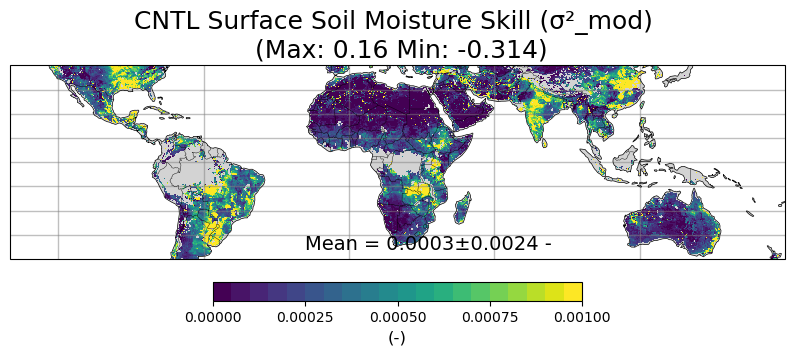

In [8]:
map_array = np.full((lons.size, 3), np.nan)
map_array[:, 1] = lons.flatten()
map_array[:, 2] = lats.flatten()

sig_cntl = S0["sigma2_mod"].flatten()
map_array[:, 0] = sig_cntl

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'CNTL Surface Soil Moisture Skill (σ²_mod) \n (Max: {maxval:.3g} Min: {minval:.3g})',
    units='-',
    cmin=-0.00,
    cmax=0.001
)


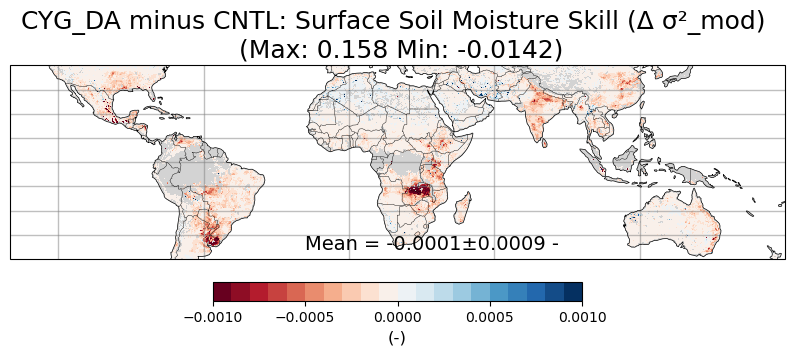

In [9]:

map_array = np.full((lons.size, 3), np.nan)
map_array[:, 1] = lons.flatten()
map_array[:, 2] = lats.flatten()



dsig2_vec = dsig2.flatten()
map_array[:, 0] = dsig2_vec

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'CYG_DA minus CNTL: Surface Soil Moisture Skill (Δ σ²_mod) \n (Max: {maxval:.3g} Min: {minval:.3g})',
    units='-',
    cmin=-0.001,
    cmax=0.001,
    cmap='RdBu'
)

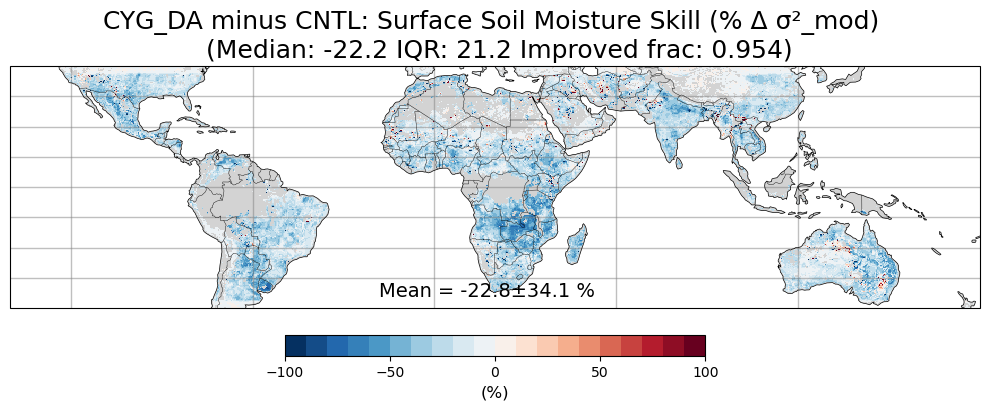

In [10]:
pct_sig2_vec = pct_sig2.flatten()

pct_sig2_plot = pct_sig2_vec.copy()

lo, hi = np.nanpercentile(pct_sig2_vec, [1, 99])
# pct_sig2_plot = np.clip(pct_sig2_vec, lo, hi)

map_array[:, 0] = pct_sig2_plot

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'CYG_DA minus CNTL: Surface Soil Moisture Skill (% Δ σ²_mod) \n (Median: {summ_pct["median"]:.3g} IQR: {summ_pct["IQR"]:.3g} Improved frac: {summ_pct["improved_frac"]:.3g})',
    units='%',
    cmin=-100.0,
    cmax=100.0,
    cmap='RdBu_r'
)
fig.tight_layout()

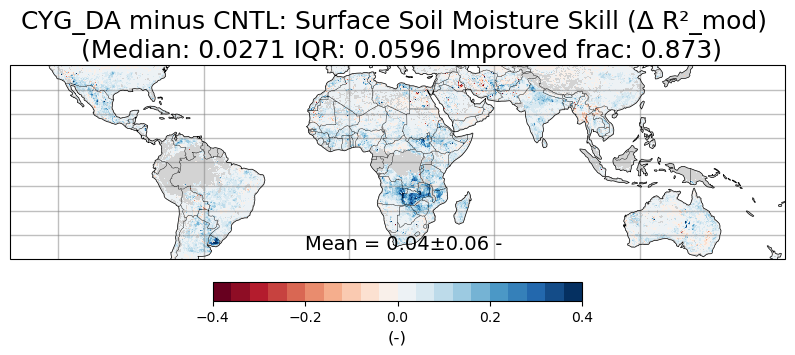

In [11]:
dR2_mod_vec = dR2_mod.flatten()
map_array[:, 0] = dR2_mod_vec

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'CYG_DA minus CNTL: Surface Soil Moisture Skill (Δ R²_mod) \n (Median: {summ_dR2["median"]:.3g} IQR: {summ_dR2["IQR"]:.3g} Improved frac: {1 -summ_dR2["improved_frac"]:.3g})',
    units='-',
    cmin=-0.4,
    cmax=0.4,
    cmap='RdBu'
)

In [12]:
def fraction_between_0_and_1(arr):
    valid = np.isfinite(arr)  # Exclude NaN values
    between_0_and_1 = (arr > 0) & (arr < 1)
    return np.sum(between_0_and_1[valid]) / np.sum(valid)

fractions = {
    "R2m0": fraction_between_0_and_1(R2m0),
    "R2m1": fraction_between_0_and_1(R2m1),
    "fMSE0": fraction_between_0_and_1(fMSE0),
    "fMSE1": fraction_between_0_and_1(fMSE1),
    "dR2_mod": fraction_between_0_and_1(dR2_mod),
    "dfMSE": fraction_between_0_and_1(dfMSE),
    "pct_fMSE": fraction_between_0_and_1(pct_fMSE),
    "dsig2": fraction_between_0_and_1(dsig2),
    "pct_sig2": fraction_between_0_and_1(pct_sig2),
}

print("Fractions of elements between 0 and 1:", fractions)

Fractions of elements between 0 and 1: {'R2m0': 0.9046179505889711, 'R2m1': 0.9042617233720134, 'fMSE0': 0.9072507408469553, 'fMSE1': 0.9329880989144119, 'dR2_mod': 0.7822069253233208, 'dfMSE': 0.06458288216752088, 'pct_fMSE': 0.0179263216150533, 'dsig2': 0.11950354609929079, 'pct_sig2': 0.01574876525952847}


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3672741396.py:3: RuntimeWarning: invalid value encountered in sqrt
  map_array[:, 0] = (np.sqrt(sigma2_ASC))
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3672741396.py:18: RuntimeWarning: invalid value encountered in sqrt
  map_array[:, 0] = (np.sqrt(sigma2_ASC)) * 200


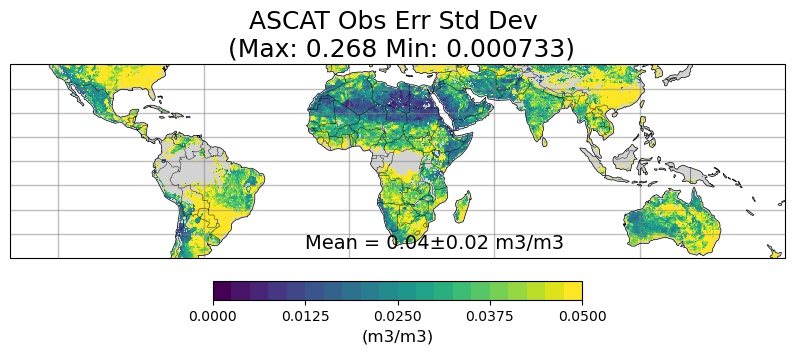

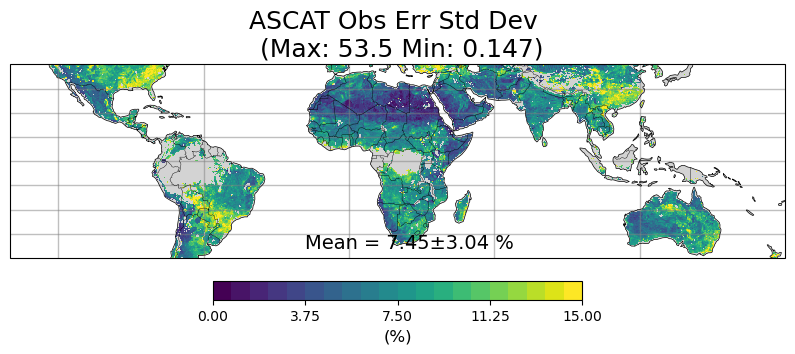

In [13]:
sigma2_ASC = grab(M0, "sigma2_ASC")

map_array[:, 0] = (np.sqrt(sigma2_ASC))
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'ASCAT Obs Err Std Dev \n (Max: {maxval:.3g} Min: {minval:.3g})',
    units='m3/m3',
    cmin=0.00,
    cmax=0.05
)

map_array[:, 0] = (np.sqrt(sigma2_ASC)) * 200
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'ASCAT Obs Err Std Dev \n (Max: {maxval:.3g} Min: {minval:.3g})',
    units='%',
    cmin=0.00,
    cmax=15
)

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/1793954941.py:6: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(sigma2_ASC)            # elementwise sqrt


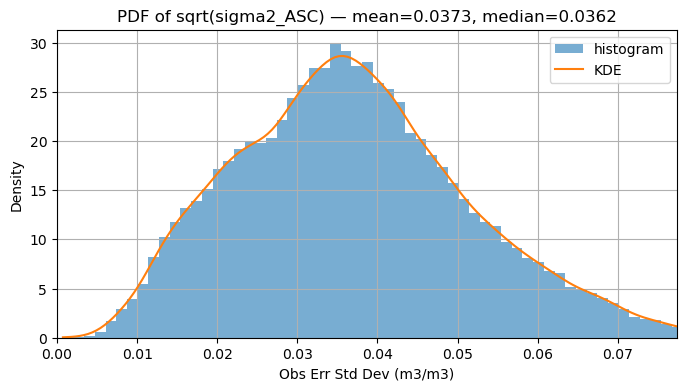

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/1793954941.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


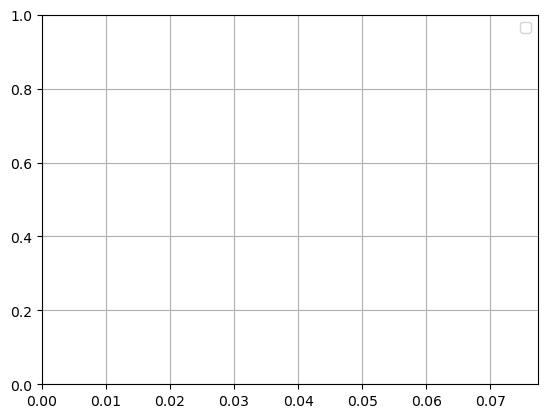

In [14]:
from scipy.stats import gaussian_kde

# Plot PDF/histogram of sqrt(sigma2_ASC)
# Assumes `sigma2_ASC` and `plt` are available in the notebook namespace.

sd = np.sqrt(sigma2_ASC)            # elementwise sqrt
sd_valid = sd[np.isfinite(sd)]      # drop NaNs/infs

# Optional: remove extreme outliers to focus plot (keep main bulk)
sd_valid = sd_valid[sd_valid <= 0.5]

plt.figure(figsize=(8, 4))
plt.hist(sd_valid, bins=200, density=True, alpha=0.6, color="C0", label="histogram")

# Overlay KDE if scipy is available
try:
    kde = gaussian_kde(sd_valid)
    xs = np.linspace(np.nanmin(sd_valid), np.nanmax(sd_valid), 512)
    plt.plot(xs, kde(xs), color="C1", lw=1.5, label="KDE")
except Exception:
    pass

plt.xlabel("Obs Err Std Dev (m3/m3)")
plt.ylabel("Density")

# add mean and median to title (handle empty arrays)
if sd_valid.size:
    mean_sd = float(np.nanmean(sd_valid))
    med_sd = float(np.nanmedian(sd_valid))
    plt.title(f"PDF of sqrt(sigma2_ASC) — mean={mean_sd:.3g}, median={med_sd:.3g}")
else:
    plt.title("PDF of sqrt(sigma2_ASC) — no valid samples")

# Set x-limit to 99th percentile to avoid extreme tail stretch
if sd_valid.size:
    plt.xlim(0, float(np.nanpercentile(sd_valid, 99)))
plt.grid(True)
plt.legend()
plt.show()
# Set x-limit to 99th percentile to avoid extreme tail stretch
if sd_valid.size:
    plt.xlim(0, float(np.nanpercentile(sd_valid, 99)))
plt.grid(True)
plt.legend()
plt.show()

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3421434697.py:16: RuntimeWarning: invalid value encountered in sqrt
  map_array[:, 0] = np.sqrt(sigma2_CYG)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3421434697.py:33: RuntimeWarning: invalid value encountered in sqrt
  map_array[:, 0] = np.sqrt(sigma2_L3)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3421434697.py:50: RuntimeWarning: invalid value encountered in sqrt
  map_array[:, 0] = (np.sqrt(sigma2_ASC))
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3421434697.py:66: RuntimeWarning: invalid value encountered in sqrt
  map_array[:, 0] = (np.sqrt(sigma2_ASC)) * 200


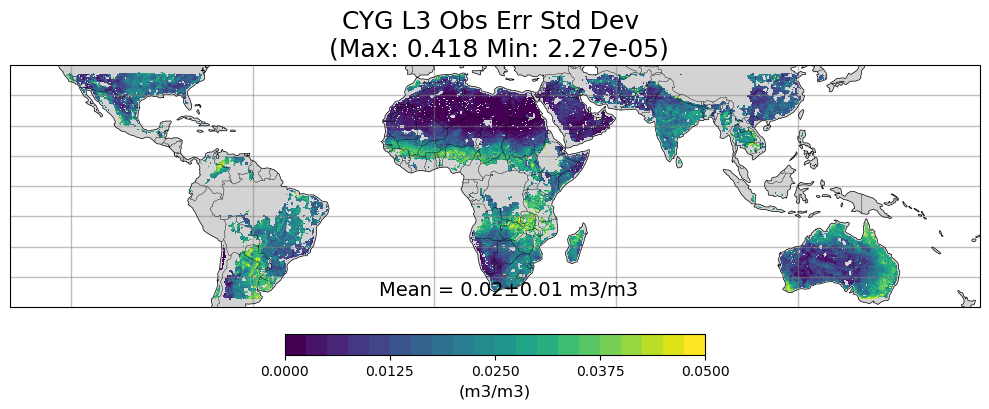

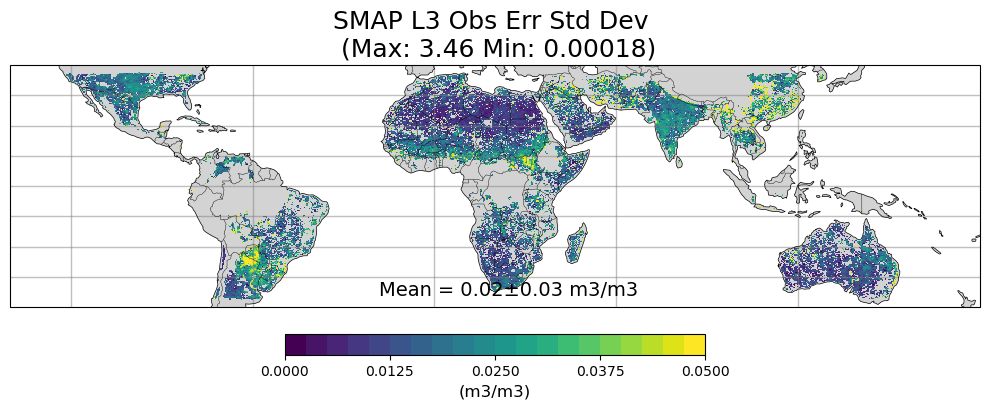

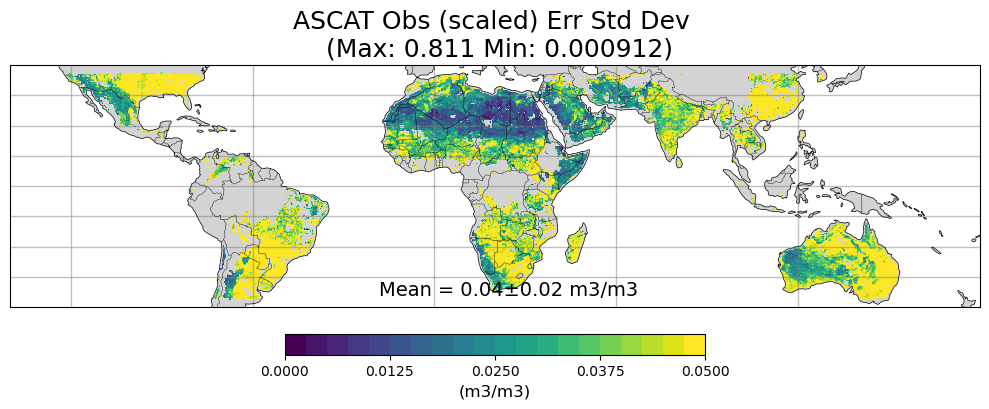

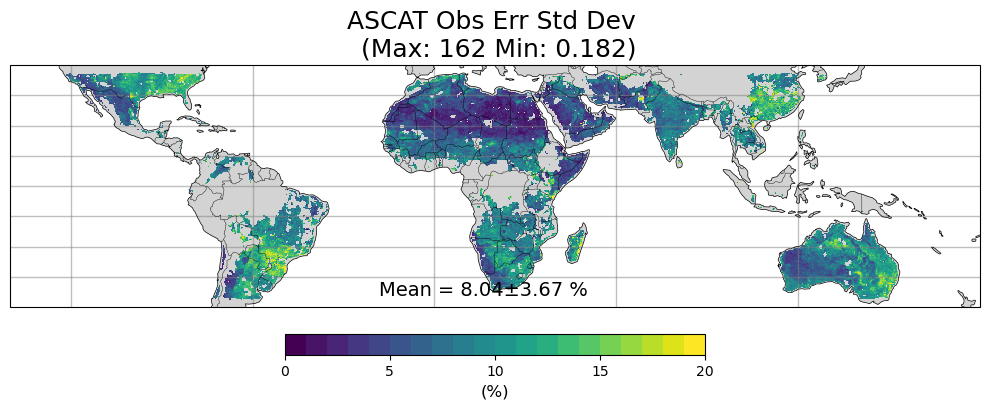

In [15]:
p_tc_obs   = Path("/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/Evaluation/IVs/ASCL4_SMPL3_CYGL3_OLv8_M36_cd_TC_stats_201808_202405.mat")
M2 = loadmat(p_tc_obs, squeeze_me=True, struct_as_record=False)

# --- grid shape from lons/lats ---
lons = grab(M2, "lons")
lats = grab(M2, "lats")
sigma2_CYG = grab(M2, "sigma2_CYG")
sigma2_L3 = grab(M2, "sigma2_L3")
sigma2_ASC = grab(M2, "sigma2_ASC")

map_array = np.empty([len(lons), 3])
map_array.fill(np.nan)
map_array[:, 1] = lons
map_array[:, 2] = lats

map_array[:, 0] = np.sqrt(sigma2_CYG)

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'CYG L3 Obs Err Std Dev \n (Max: {maxval:.3g} Min: {minval:.3g})',
    units='m3/m3',
    cmin=0.00,
    cmax=0.05
)
fig.tight_layout()

map_array[:, 0] = np.sqrt(sigma2_L3)

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'SMAP L3 Obs Err Std Dev \n (Max: {maxval:.3g} Min: {minval:.3g})',
    units='m3/m3',
    cmin=0.00,
    cmax=0.05
)
fig.tight_layout()

map_array[:, 0] = (np.sqrt(sigma2_ASC))
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'ASCAT Obs (scaled) Err Std Dev \n (Max: {maxval:.3g} Min: {minval:.3g})',
    units='m3/m3',
    cmin=0.00,
    cmax=0.05
)
fig.tight_layout()

map_array[:, 0] = (np.sqrt(sigma2_ASC)) * 200
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'ASCAT Obs Err Std Dev \n (Max: {maxval:.3g} Min: {minval:.3g})',
    units='%',
    cmin=0.00,
    cmax=20.0
)
fig.tight_layout()

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/2654356481.py:1: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(sigma2_ASC)            # elementwise sqrt


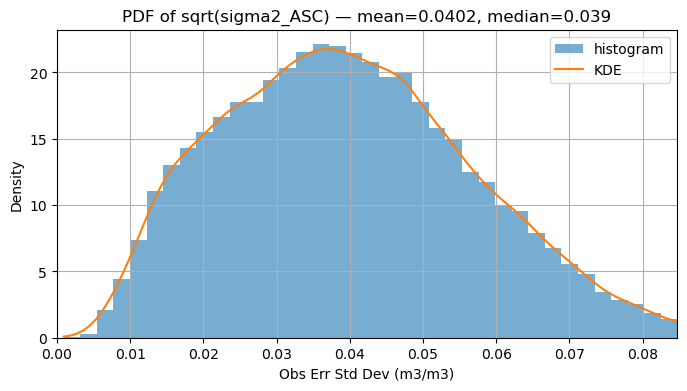

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/2654356481.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


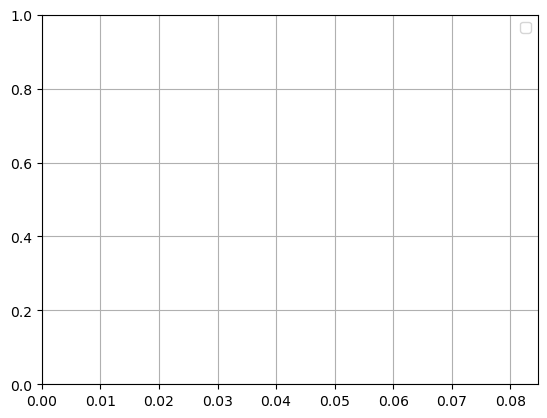

In [16]:

sd = np.sqrt(sigma2_ASC)            # elementwise sqrt
sd_valid = sd[np.isfinite(sd)]      # drop NaNs/infs

# Optional: remove extreme outliers to focus plot (keep main bulk)
sd_valid = sd_valid[sd_valid <= 0.5]

plt.figure(figsize=(8, 4))
plt.hist(sd_valid, bins=200, density=True, alpha=0.6, color="C0", label="histogram")

# Overlay KDE if scipy is available
try:
    kde = gaussian_kde(sd_valid)
    xs = np.linspace(np.nanmin(sd_valid), np.nanmax(sd_valid), 512)
    plt.plot(xs, kde(xs), color="C1", lw=1.5, label="KDE")
except Exception:
    pass

plt.xlabel("Obs Err Std Dev (m3/m3)")
plt.ylabel("Density")

# add mean and median to title (handle empty arrays)
if sd_valid.size:
    mean_sd = float(np.nanmean(sd_valid))
    med_sd = float(np.nanmedian(sd_valid))
    plt.title(f"PDF of sqrt(sigma2_ASC) — mean={mean_sd:.3g}, median={med_sd:.3g}")
else:
    plt.title("PDF of sqrt(sigma2_ASC) — no valid samples")

# Set x-limit to 99th percentile to avoid extreme tail stretch
if sd_valid.size:
    plt.xlim(0, float(np.nanpercentile(sd_valid, 99)))
plt.grid(True)
plt.legend()
plt.show()
# Set x-limit to 99th percentile to avoid extreme tail stretch
if sd_valid.size:
    plt.xlim(0, float(np.nanpercentile(sd_valid, 99)))
plt.grid(True)
plt.legend()
plt.show()

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3038961371.py:4: RuntimeWarning: invalid value encountered in sqrt
  CYG_sd = np.sqrt(sigma2_CYG)
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3038961371.py:5: RuntimeWarning: invalid value encountered in sqrt
  SMP_sd = np.sqrt(sigma2_L3)


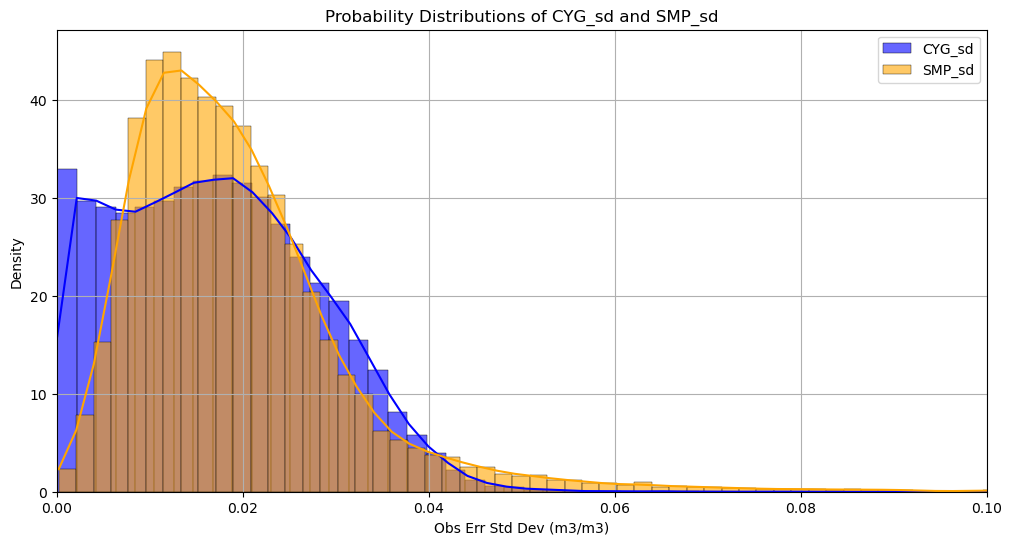

In [17]:
import seaborn as sns

# Flatten the fMSE arrays and remove NaN values
CYG_sd = np.sqrt(sigma2_CYG)
SMP_sd = np.sqrt(sigma2_L3)

CYG_sd_clean = CYG_sd[np.isfinite(CYG_sd)]
SMP_sd_clean = SMP_sd[np.isfinite(SMP_sd)]

# Replace any values greater than 0.5 with NaN
CYG_sd_clean = CYG_sd_clean[CYG_sd_clean <= 0.5]
SMP_sd_clean = SMP_sd_clean[SMP_sd_clean <= 0.5]

# Plot histograms and KDEs
plt.figure(figsize=(12, 6))
sns.histplot(CYG_sd_clean, bins=200, kde=True, color='blue', label='CYG_sd', stat='density', alpha=0.6)
sns.histplot(SMP_sd_clean, bins=200, kde=True, color='orange', label='SMP_sd', stat='density', alpha=0.6)

plt.title('Probability Distributions of CYG_sd and SMP_sd')
plt.xlabel('Obs Err Std Dev (m3/m3)')
plt.ylabel('Density')
plt.xlim(0, 0.1)  # Limit x-axis to focus on the main distribution
plt.legend()
plt.grid(True)
plt.show()

In [18]:
fn = "/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/Evaluation/IVs/aridity_indices_model_net_rad_20180801_20240630.nc4"

# open dataset and inspect
ds = xr.open_dataset(fn, decode_times=True)
print(ds)                 # quick view of variables / coords
print("time values:", ds['time'].values)

ai = ds['AI_clim'].values   # shape (tile,)
lon = ds['lon'].isel(time=1).values                      # coords usually constant per tile
lat = ds['lat'].isel(time=1).values
title_time = "Climatology"

print('max.min of lon, lat, ai:')
print(np.nanmax(lon), np.nanmin(lon))
print(np.nanmax(lat), np.nanmin(lat))
print(np.nanmax(ai), np.nanmin(ai))

<xarray.Dataset> Size: 18MB
Dimensions:             (time: 7, tile: 70773)
Coordinates:
  * time                (time) datetime64[ns] 56B 2018-01-01 ... 2024-01-01
  * tile                (tile) int64 566kB 0 1 2 3 4 ... 70769 70770 70771 70772
    lat                 (time, tile) float32 2MB ...
    lon                 (time, tile) float32 2MB ...
    year                (time) int64 56B ...
Data variables: (12/13)
    AI                  (time, tile) float32 2MB ...
    Budyko_phi          (time, tile) float32 2MB ...
    CMI                 (time, tile) float32 2MB ...
    DeMartonne          (time, tile) float32 2MB ...
    AI_clim             (tile) float32 283kB ...
    Budyko_phi_clim     (tile) float32 283kB ...
    ...                  ...
    DeMartonne_clim     (tile) float32 283kB ...
    P_annual            (time, tile) float32 2MB ...
    PET_annual          (time, tile) float32 2MB ...
    mean_greeness_clim  (tile) float32 283kB ...
    mean_lai_clim       (tile) float3

AI_clim Climatology max 6.19 min 0.00047


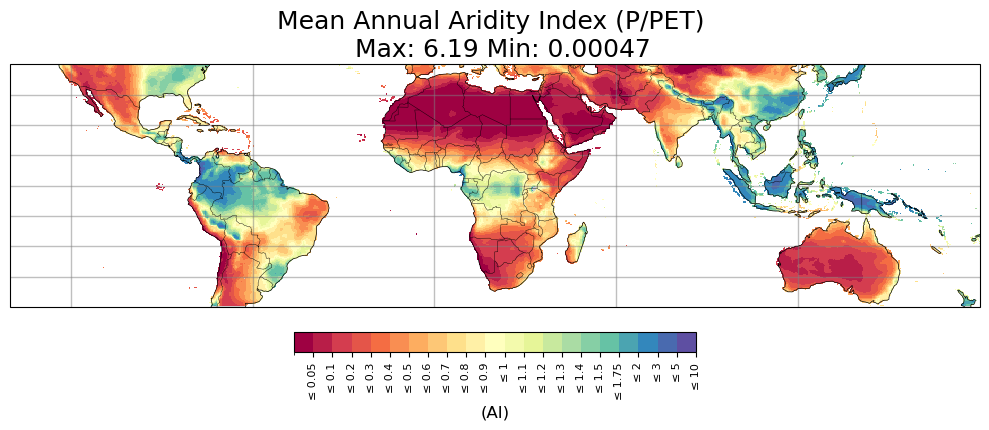

In [19]:
ai_flat = np.squeeze(ai)
lon_flat = np.squeeze(lon)
lat_flat = np.squeeze(lat)
n = ai_flat.size

map_array = np.empty((n, 3), dtype=float)
map_array.fill(np.nan)
map_array[:, 0] = ai_flat
map_array[:, 1] = lon_flat
map_array[:, 2] = lat_flat

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

print(f"AI_clim {title_time} max {maxval:.3g} min {minval:.3g}")

# 21 bin edges (same thresholds as the legend)
ai_edges = np.array([
    0.00, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60,
    0.70, 0.80, 0.90, 1.00, 1.10, 1.20, 1.30, 1.40,
    1.50, 1.75, 2.00, 3.00, 5.00, 10.00
])

# --- Example usage with an array 'AI' (same shape as your map) --
# Create a colormap with 20 colors (one for each bin)
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=False,
    plot_title=f"Mean Annual Aridity Index (P/PET) \n  Max: {maxval:.3g} Min: {minval:.3g}",
    units='AI',
    cmin=0,
    cmax=0.6,
    discrete_edges=ai_edges,     # <<< turn on discrete Spectral
    base_cmap="Spectral"
)
fig.tight_layout()
plt.show()

mean_lai_clim max 5.73 min 0


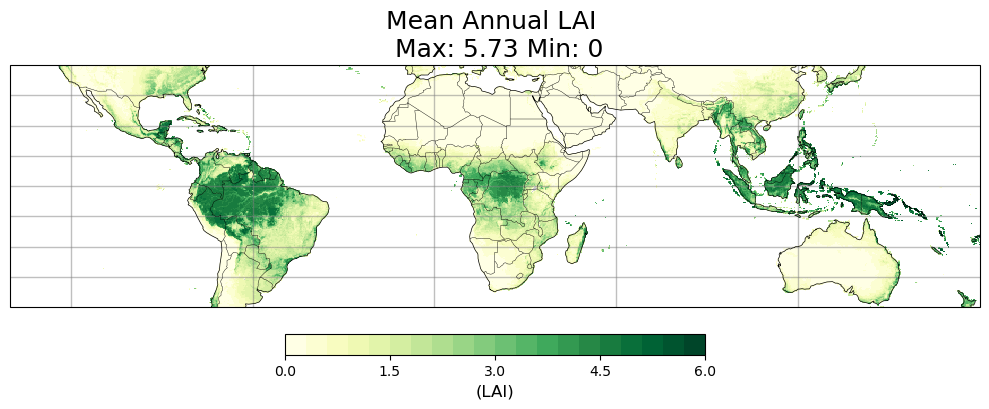

In [20]:
# Extract mean_lai_clim from the dataset
mean_lai_clim = ds['mean_lai_clim'].values  # shape (tile,)

# Flatten and build map array expected by plot_region: columns [value, lon, lat]
mean_lai_flat = np.squeeze(mean_lai_clim)
map_array = np.empty((n, 3), dtype=float)
map_array.fill(np.nan)
map_array[:, 0] = mean_lai_flat
map_array[:, 1] = lon_flat
map_array[:, 2] = lat_flat

# Calculate max and min values for the plot
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

print(f"mean_lai_clim max {maxval:.3g} min {minval:.3g}")

# Plot the map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=False,
    plot_title=f"Mean Annual LAI \n Max: {maxval:.3g} Min: {minval:.3g}",
    units='LAI',
    cmin=0,
    cmax=6,
    cmap="YlGn"
)
fig.tight_layout()
plt.show()

max_lai_clim max 6.22 min 0


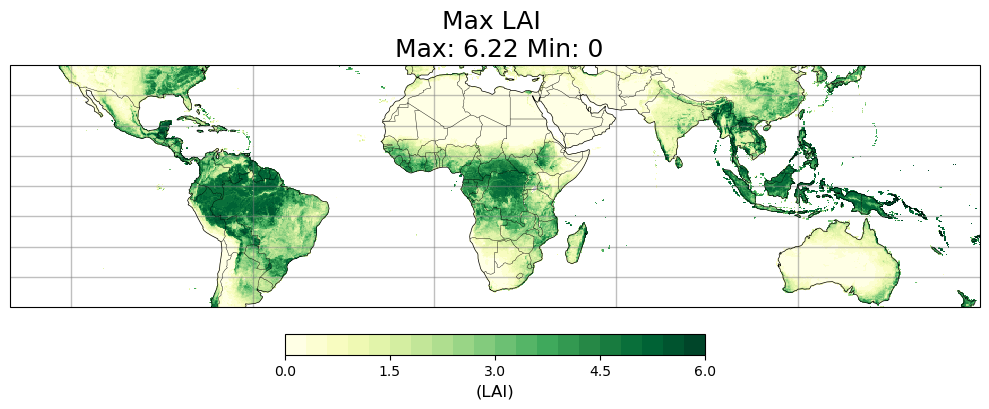

In [21]:
# Extract max_lai_clim from the dataset
max_lai_clim = ds['max_lai_clim'].values  # shape (tile,)

# Flatten and build map array expected by plot_region: columns [value, lon, lat]
max_lai_flat = np.squeeze(max_lai_clim)
map_array = np.empty((n, 3), dtype=float)
map_array.fill(np.nan)
map_array[:, 0] = max_lai_flat
map_array[:, 1] = lon_flat
map_array[:, 2] = lat_flat

# Calculate max and min values for the plot
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

print(f"max_lai_clim max {maxval:.3g} min {minval:.3g}")

# Plot the map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=False,
    plot_title=f"Max LAI \n Max: {maxval:.3g} Min: {minval:.3g}",
    units='LAI',
    cmin=0,
    cmax=6,
    cmap="YlGn"
)
fig.tight_layout()
plt.show()

mean_greeness_clim max 0.992 min 0.0511


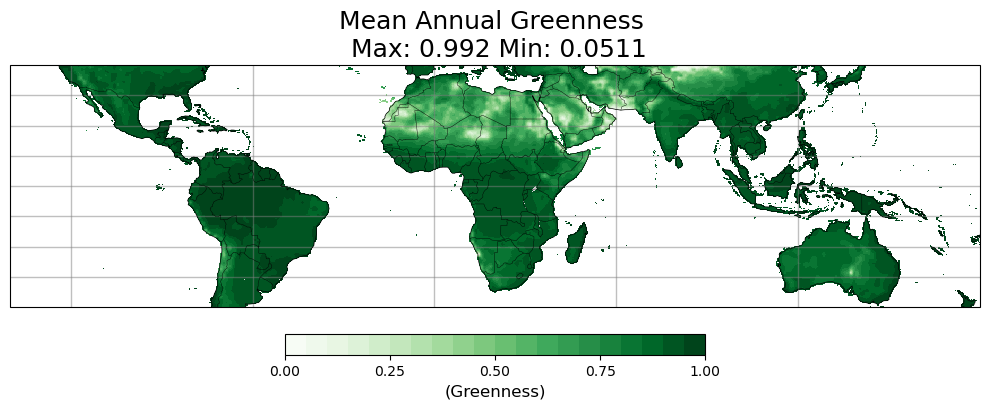

In [22]:
# Extract mean_greeness_clim from the dataset
mean_greeness_clim = ds['mean_greeness_clim'].values  # shape (tile,)

# Flatten and build map array expected by plot_region: columns [value, lon, lat]
mean_greeness_flat = np.squeeze(mean_greeness_clim)
map_array = np.empty((n, 3), dtype=float)
map_array.fill(np.nan)
map_array[:, 0] = mean_greeness_flat
map_array[:, 1] = lon_flat
map_array[:, 2] = lat_flat

# Calculate max and min values for the plot
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

print(f"mean_greeness_clim max {maxval:.3g} min {minval:.3g}")

# Plot the map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=False,
    plot_title=f"Mean Annual Greenness \n Max: {maxval:.3g} Min: {minval:.3g}",
    units='Greenness',
    cmin=0,
    cmax=1,
    cmap="Greens"
)
fig.tight_layout()
plt.show()


<xarray.Dataset> Size: 7MB
Dimensions:               (tile: 70773)
Dimensions without coordinates: tile
Data variables: (12/26)
    GRN_mean              (tile) float32 283kB ...
    GRN_std               (tile) float32 283kB ...
    LAI_mean              (tile) float32 283kB ...
    LAI_std               (tile) float32 283kB ...
    GWETPROF_mean         (tile) float32 283kB ...
    GWETPROF_std          (tile) float32 283kB ...
    ...                    ...
    SHLAND_mean           (tile) float32 283kB ...
    SHLAND_std            (tile) float32 283kB ...
    LHLAND_mean           (tile) float32 283kB ...
    LHLAND_std            (tile) float32 283kB ...
    EVLAND_mean           (tile) float32 283kB ...
    EVLAND_std            (tile) float32 283kB ...
Attributes:
    CreatedBy:  
    Date:       2025-07-01 at 21:05:21
Data variables in dataset: ['GRN_mean', 'GRN_std', 'LAI_mean', 'LAI_std', 'GWETPROF_mean', 'GWETPROF_std', 'GWETROOT_mean', 'GWETROOT_std', 'GWETTOP_mean', 'GWET

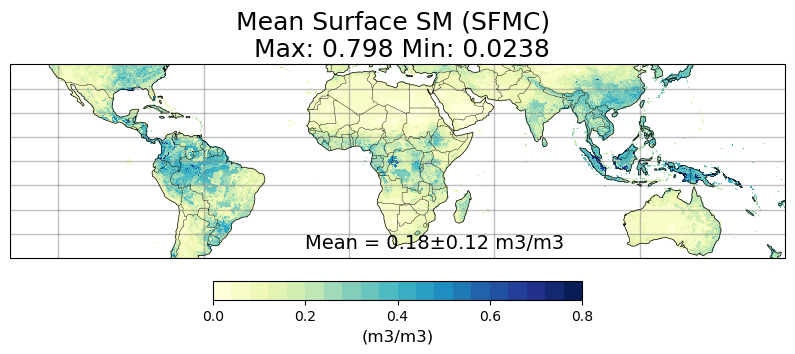

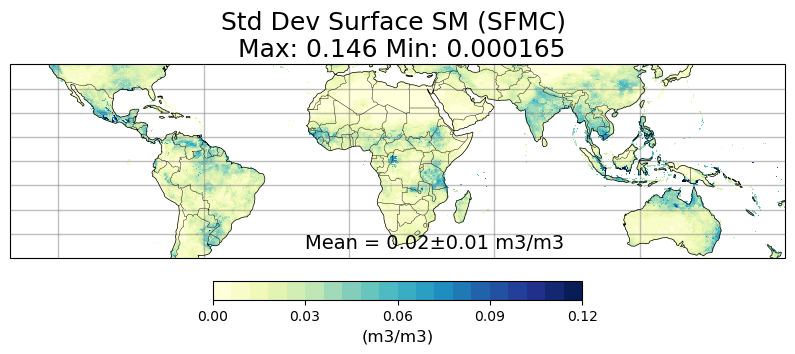

In [23]:
fn = "/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/OLv8_M36_cd/OLv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg/expt_means_20180801_20240630.nc4"

# open dataset and inspect
ds = xr.open_dataset(fn, decode_times=True)
print(ds)                 # quick view of variables / coords
print("Data variables in dataset:", list(ds.data_vars))



map_array[:,0] = ds['SFMC_mean'].values

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f"Mean Surface SM (SFMC) \n Max: {maxval:.3g} Min: {minval:.3g}",
    units='m3/m3',
    cmin=0,
    cmax=0.8,
    cmap="YlGnBu"
)

# and std dev
map_array[:,0] = ds['SFMC_std'].values
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
# Plot group map
fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f"Std Dev Surface SM (SFMC) \n Max: {maxval:.3g} Min: {minval:.3g}",
    units='m3/m3',
    cmin=0,
    cmax=0.12,
    cmap="YlGnBu"
)


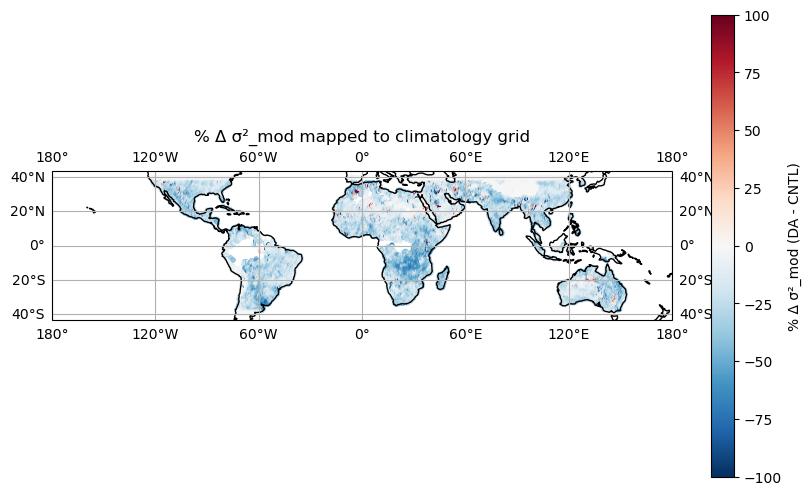

In [24]:
# ...existing code...
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial import cKDTree
import cartopy.crs as ccrs

# Ensure coordinate vectors exist for KDTree inputs
if "lons_vec" not in globals():
    if "lons" in globals():
        lons_vec = np.ravel(lons)
        lats_vec = np.ravel(lats)
    else:
        lons_vec = np.ravel(lon_flat)
        lats_vec = np.ravel(lat_flat)

# inputs expected in notebook namespace: lons_vec, lats_vec, lon_flat, lat_flat, pct_sig2_vec, sigma2_CYG
# build points
vec_pts = np.column_stack((np.ravel(lons_vec), np.ravel(lats_vec)))
flat_pts = np.column_stack((np.ravel(lon_flat), np.ravel(lat_flat)))

# build KDTree and query
kdtree = cKDTree(vec_pts)
_, idxs = kdtree.query(flat_pts, k=1)

# map the vector field pct_sig2_vec to the flattened grid order
pct_sig2_flat_to_map = pct_sig2_vec[idxs]

# reshape to grid like lon_flat (if lon_flat is 1D, keep 1D)
try:
    grid_shape = lon_flat.shape
except NameError:
    grid_shape = pct_sig2_flat_to_map.shape
pct_map = pct_sig2_flat_to_map.reshape(grid_shape)

# Plot as scatter (lon/lat are 1D tile coords)
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
sc = ax.scatter(lon_flat, lat_flat, c=pct_map, cmap='RdBu_r', vmin=-100, vmax=100, s=12,
                edgecolor='none', transform=ccrs.PlateCarree())
ax.coastlines(); ax.gridlines(draw_labels=True)
plt.colorbar(sc, ax=ax, label='% Δ σ²_mod (DA - CNTL)')
plt.title('% Δ σ²_mod mapped to climatology grid')
plt.show()


In [25]:

target_dR2 = np.ravel(dR2_mod_vec)[idxs]
target_dR2_name = "Δ R²_mod (DA - CNTL)"
# Clip extreme outliers, keep between 1 and 99 percentiles
p_low, p_high = np.nanpercentile(target_dR2, [1, 99])
target_dR2 = np.where((target_dR2 < p_low) | (target_dR2 > p_high), np.nan, target_dR2)
print(f"target_dR2 clipped to 1-99% range: {p_low:.3g} to {p_high:.3g}")

target_pct_sig2 = np.ravel(pct_sig2_vec)[idxs]
target_pct_sig2_name = "% Δ σ²_mod (DA vs CNTL)"
# Clip extreme outliers, keep between 1 and 99 percentiles
p_low, p_high = np.nanpercentile(target_pct_sig2, [1, 99])
target_pct_sig2 = np.where((target_pct_sig2 < p_low) | (target_pct_sig2 > p_high), np.nan, target_pct_sig2)
print(f"target_pct_sig2 clipped to 1-99% range: {p_low:.3g} to {p_high:.3g}")

pred_sigma2_CYG = np.ravel(sigma2_CYG)[idxs]
p_low, p_high = np.nanpercentile(pred_sigma2_CYG, [1, 99])
pred_sigma2_CYG = np.where((pred_sigma2_CYG < p_low) | (pred_sigma2_CYG > p_high), np.nan, pred_sigma2_CYG)
pred_sigma2_CYG_name = "CYG L3 Obs Err Variance"

pred_ai = np.ravel(ai_flat)
p_low, p_high = np.nanpercentile(pred_ai, [1, 99])
pred_ai = np.where((pred_ai < p_low) | (pred_ai > p_high), np.nan, pred_ai)
pred_ai_name = "Aridity Index (P/PET)"

pred_mean_lai = np.ravel(mean_lai_flat)
p_low, p_high = np.nanpercentile(pred_mean_lai, [1, 99])
pred_mean_lai = np.where((pred_mean_lai < p_low) | (pred_mean_lai > p_high), np.nan, pred_mean_lai)
pred_mean_lai_name = "Mean Annual LAI (m2/m2)"

pred_mean_greeness = np.ravel(mean_greeness_flat)
p_low, p_high = np.nanpercentile(pred_mean_greeness, [1, 99])
pred_mean_greeness = np.where((pred_mean_greeness < p_low) | (pred_mean_greeness > p_high), np.nan, pred_mean_greeness)
pred_mean_greeness_name = "Mean Annual Greenness"

pred_mean_sm = np.ravel(ds['SFMC_mean'].values)
p_low, p_high = np.nanpercentile(pred_mean_sm, [1, 99])
pred_mean_sm = np.where((pred_mean_sm < p_low) | (pred_mean_sm > p_high), np.nan, pred_mean_sm)
pred_mean_sm_name = "Mean Surface SM (SFMC)"

pred_std_sm = np.ravel(ds['SFMC_std'].values)
p_low, p_high = np.nanpercentile(pred_std_sm, [1, 99])
pred_std_sm = np.where((pred_std_sm < p_low) | (pred_std_sm > p_high), np.nan, pred_std_sm)
pred_std_sm_name = "Std Dev Surface SM (SFMC)"

pred_sigma2_mod0 = np.ravel(S0['sigma2_mod'])[idxs]
p_low, p_high = np.nanpercentile(pred_sigma2_mod0, [1, 99])
pred_sigma2_mod0 = np.where((pred_sigma2_mod0 < p_low) | (pred_sigma2_mod0 > p_high), np.nan, pred_sigma2_mod0)
pred_sigma2_mod0_name = "CNTL Model Error Variance"


target_dR2 clipped to 1-99% range: -0.0668 to 0.253
target_pct_sig2 clipped to 1-99% range: -69.9 to 19.3


In [26]:


def analyze_and_plot(pred_vec, pred_name, target, target_name, show=True):
    pred_vec = np.asarray(pred_vec).ravel()
    target = np.asarray(target).ravel()

    if pred_vec.size != target.size:
        print(f"Size mismatch: target={target.size}, predictor '{pred_name}'={pred_vec.size}. Skipping.")
        return None

    mask = np.isfinite(target) & np.isfinite(pred_vec)
    if mask.sum() == 0:
        print(f"{pred_name}: no valid samples")
        return None

    x = pred_vec[mask]
    y = target[mask]

    pear_r, pear_p = stats.pearsonr(x, y)
    spear_r, spear_p = stats.spearmanr(x, y)
    lm = stats.linregress(x, y)

    result = {
        "n": int(mask.sum()),
        "pearson_r": float(pear_r), "pearson_p": float(pear_p),
        "spearman_r": float(spear_r), "spearman_p": float(spear_p),
        "slope": float(lm.slope), "intercept": float(lm.intercept),
        "lm_r": float(lm.rvalue), "lm_p": float(lm.pvalue)
    }

    if show:
        plt.figure(figsize=(5,4))
        sns.scatterplot(x=x, y=y, s=10, alpha=0.4)
        xs = np.linspace(np.nanmin(x), np.nanmax(x), 200)
        plt.plot(xs, lm.intercept + lm.slope*xs, color="red", linewidth=1)
        plt.xlabel(pred_name)
        plt.ylabel(target_name)
        plt.title(f"{pred_name} vs {target_name}\ n={result['n']}  pearson r={pear_r:.2f} (p={pear_p:.2g})")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return result


=== Summary for Δ R²_mod (DA - CNTL) (sorted by |Pearson r|) ===
                   predictor      n  pearson_r      pearson_p  spearman_r  \
0    CYG L3 Obs Err Variance  33856   0.357541   0.000000e+00    0.439575   
6  CNTL Model Error Variance  46197   0.312167   0.000000e+00    0.455877   
3      Mean Annual Greenness  46418   0.216181   0.000000e+00    0.281681   
5  Std Dev Surface SM (SFMC)  46227   0.193160   0.000000e+00    0.268923   
2    Mean Annual LAI (m2/m2)  46908   0.177454   0.000000e+00    0.312342   
4     Mean Surface SM (SFMC)  46330   0.176212  1.001273e-319    0.280741   
1      Aridity Index (P/PET)  46473   0.088071   1.110188e-80    0.239939   

   spearman_p      slope  intercept  
0         0.0  43.783650   0.024337  
6         0.0  40.197754   0.025010  
3         0.0   0.072754  -0.022060  
5         0.0   0.697411   0.024338  
2         0.0   0.008309   0.029989  
4         0.0   0.087602   0.025060  
1         0.0   0.008624   0.033818  

=== Summary 

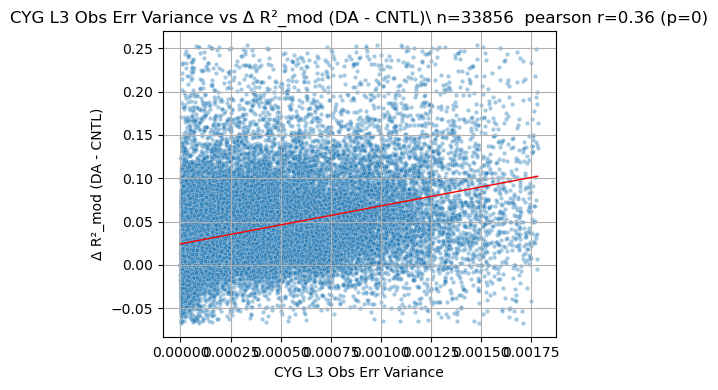

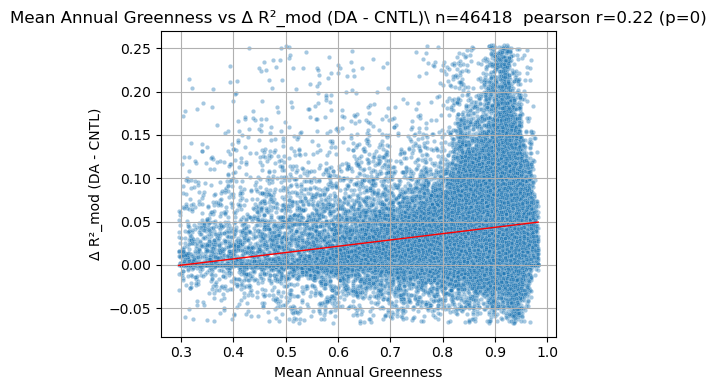

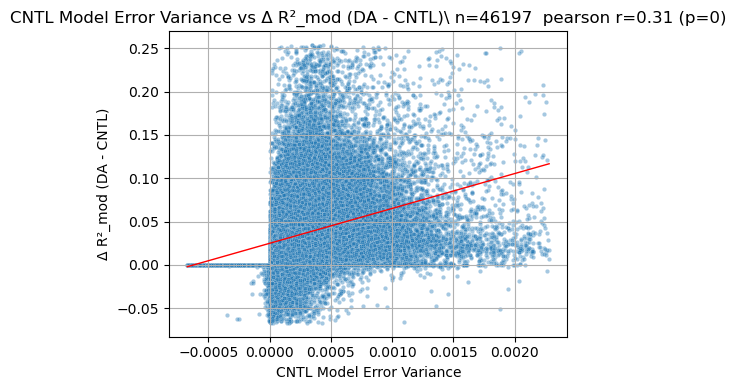


Plotting top 3 predictors for: % Δ σ²_mod (DA vs CNTL)


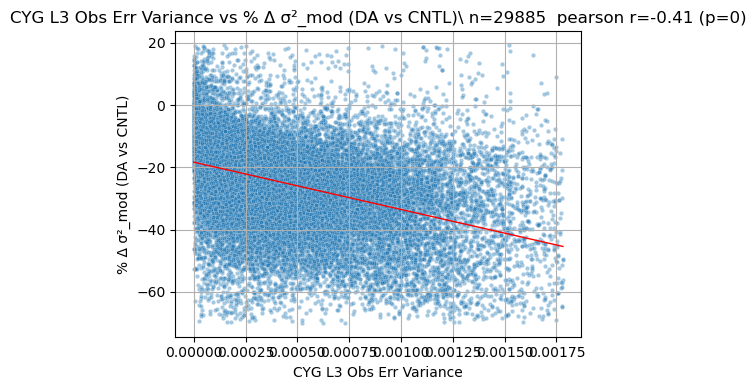

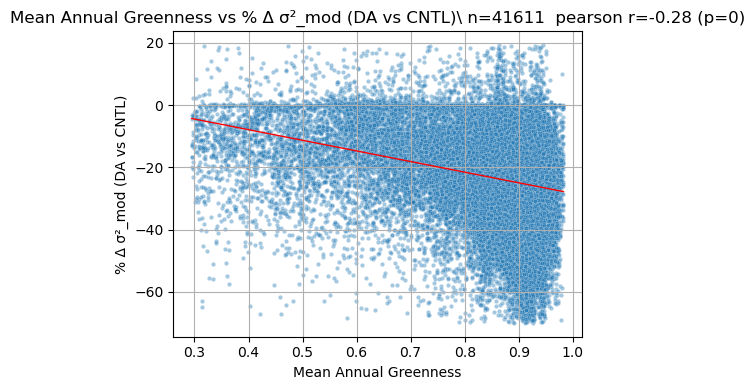

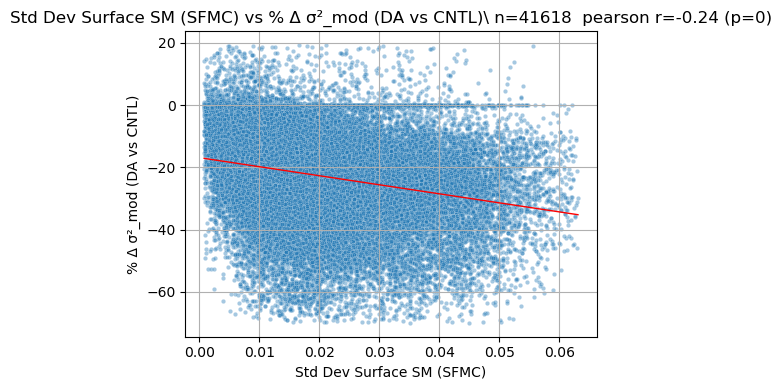

In [27]:
import numpy as np
import pandas as pd

# ---- bundle predictors ----
predictors = [
    (pred_sigma2_CYG,    pred_sigma2_CYG_name),
    (pred_ai,            pred_ai_name),
    (pred_mean_lai,      pred_mean_lai_name),
    (pred_mean_greeness, pred_mean_greeness_name),
    (pred_mean_sm,       pred_mean_sm_name),
    (pred_std_sm,        pred_std_sm_name),
    (pred_sigma2_mod0,   pred_sigma2_mod0_name),
]

# ---- bundle targets ----
targets = [
    (target_dR2,       target_dR2_name),
    (target_pct_sig2,  target_pct_sig2_name),
]

# ---- run all pairs, no plots first (show=False), collect results ----
rows = []
for t_vec, t_name in targets:
    for x_vec, x_name in predictors:
        res = analyze_and_plot(x_vec, x_name, t_vec, t_name, show=False)
        if res is None:
            continue
        rows.append({
            "target": t_name,
            "predictor": x_name,
            **res
        })

results_df = pd.DataFrame(rows)

# display a quick summary sorted by |Pearson r| within each target
def summarize(df, target_name):
    sub = df[df["target"] == target_name].copy()
    if sub.empty:
        print(f"No results for {target_name}")
        return sub
    sub["abs_pearson_r"] = sub["pearson_r"].abs()
    sub = sub.sort_values("abs_pearson_r", ascending=False)
    print(f"\n=== Summary for {target_name} (sorted by |Pearson r|) ===")
    print(sub[["predictor","n","pearson_r","pearson_p","spearman_r","spearman_p","slope","intercept"]])
    return sub

_ = summarize(results_df, target_dR2_name)
_ = summarize(results_df, target_pct_sig2_name)

# ---- (optional) make scatter plots for the top-K predictors per target ----
TOP_K = 3
for t_vec, t_name in targets:
    sub = results_df[results_df["target"] == t_name].copy()
    if sub.empty:
        continue
    top_pred_names = sub.assign(abs_r=sub["pearson_r"].abs()) \
                        .sort_values("abs_r", ascending=False) \
                        .head(TOP_K)["predictor"].tolist()
    print(f"\nPlotting top {TOP_K} predictors for: {t_name}")
    for x_vec, x_name in predictors:
        if x_name in top_pred_names:
            analyze_and_plot(x_vec, x_name, t_vec, t_name, show=True)


In [28]:
import numpy as np
import pandas as pd

def multivar_summary_np(target, target_name):
    """
    Standardized (beta) coefficients and R^2 using only NumPy.
    Z-scores X and y, solves least-squares, reports betas sorted by |beta|.
    """
    # Build DataFrame (align NaNs)
    df = pd.DataFrame({
        "target": target,
        "CYG_errvar": pred_sigma2_CYG,
        "CNTL_errvar": pred_sigma2_mod0,
        "Greenness": pred_mean_greeness,
        "LAI": pred_mean_lai,
        "MeanSM": pred_mean_sm,
        "StdSM": pred_std_sm,
        # add more predictors here if you want
    }).replace([np.inf, -np.inf], np.nan).dropna()

    if df.empty:
        print(f"{target_name}: no valid rows")
        return None

    y = df["target"].values.astype(float)
    X = df.drop(columns=["target"]).values.astype(float)
    names = df.drop(columns=["target"]).columns.to_list()

    # Z-score (standardize)
    Xmean = np.nanmean(X, axis=0); Xstd = np.nanstd(X, axis=0, ddof=0)
    ymean = np.nanmean(y);         ystd = np.nanstd(y, ddof=0)

    # guard against zero std
    Xstd = np.where(Xstd == 0, 1.0, Xstd)
    ystd = 1.0 if ystd == 0 else ystd

    Xz = (X - Xmean) / Xstd
    yz = (y - ymean) / ystd

    # Least-squares: betas on standardized vars
    # (no intercept needed because standardized)
    betas, residuals, rank, s = np.linalg.lstsq(Xz, yz, rcond=None)

    # R^2 on standardized variables
    yhat = Xz @ betas
    ss_res = np.sum((yz - yhat) ** 2)
    ss_tot = np.sum((yz - yz.mean()) ** 2)  # yz.mean() ~ 0
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    out = pd.DataFrame({"predictor": names, "std_beta": betas})
    out["abs_beta"] = np.abs(out["std_beta"])
    out = out.sort_values("abs_beta", ascending=False).drop(columns="abs_beta")

    print(f"\n{target_name}: standardized betas (abs-sorted), n={len(df)}, R²={r2:.3f}")
    print(out.to_string(index=False))
    return out, r2

_ = multivar_summary_np(target_dR2,      target_dR2_name)
_ = multivar_summary_np(target_pct_sig2, target_pct_sig2_name)



Δ R²_mod (DA - CNTL): standardized betas (abs-sorted), n=32100, R²=0.195
  predictor  std_beta
CNTL_errvar  0.357337
 CYG_errvar  0.320430
      StdSM -0.148621
        LAI -0.018156
  Greenness -0.013357
     MeanSM -0.011928

% Δ σ²_mod (DA vs CNTL): standardized betas (abs-sorted), n=28953, R²=0.187
  predictor  std_beta
 CYG_errvar -0.329804
CNTL_errvar -0.139991
     MeanSM -0.087117
  Greenness -0.085484
        LAI  0.050426
      StdSM  0.046336


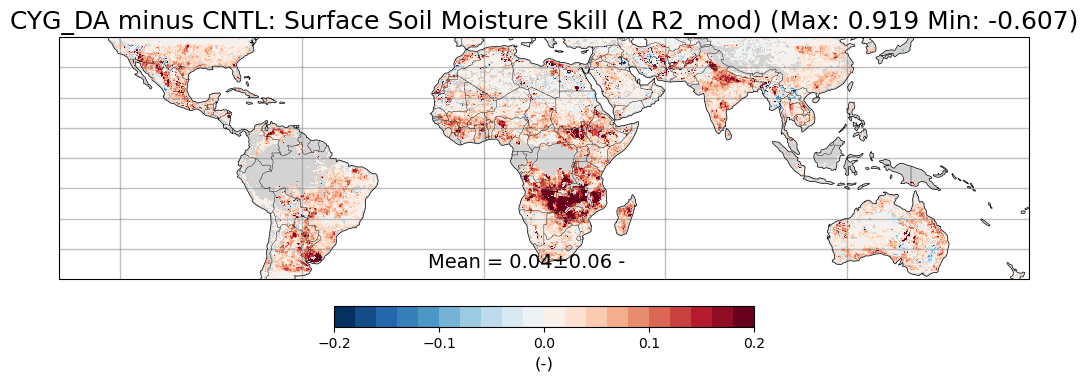

In [29]:
# Plot ΔR2_mod on the TC grid using existing lons/lats and dR2_mod
import numpy as np

lon_vec = np.ravel(lons)
lat_vec = np.ravel(lats)
dR2_vec = np.ravel(dR2_mod)

map_array = np.column_stack((dR2_vec, lon_vec, lat_vec))

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])

fig, ax = plot_region(
    map_array,
    region_bounds=REGION_BOUNDS['cygnss'],
    meanflag=True,
    plot_title=f'CYG_DA minus CNTL: Surface Soil Moisture Skill (Δ R2_mod) (Max: {maxval:.3g} Min: {minval:.3g})',
    units='-',
    cmin=-0.2,
    cmax=0.2,
    cmap='RdBu_r'
)
fig.tight_layout()


In [30]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path

from read_GEOSldas import read_tilecoord

# Load tile coordinates to get tile_id, com_lon, com_lat
ftc = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd/DAv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/rc_out/DAv8_M36_cd.ldas_tilecoord.bin'

tc = read_tilecoord(ftc)
tile_id = np.array(tc['tile_id'], dtype=int)
lon_flat = tc['com_lon']
lat_flat = tc['com_lat']
com_lon = tc['com_lon']
com_lat = tc['com_lat']
n_tiles = len(tile_id)


mosaic_path = "/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/mosaic_veg_typs_fracs"

# --- thresholds & codes ---
PRIMARY_THRESH = 49.0
BARE_MAX = 10.0          # total < 0.10  -> bare
SPARSE_MAX = 20.0        # 0.10 <= total <= 0.20 -> sparse
MIXED_MIN = 20.0         # total > 0.20 and primary <= 0.50 -> mixed

BARE_CODE   = 0
MIXED_CODE  = 7
SPARSE_CODE = 8

# --- read whitespace-delimited text file ---
cols = ["tile_index","pfaf_code","primary_veg_type","secondary_veg_type",
        "primary_veg_frac","secondary_veg_frac","canopy_height","ASCATz0"]

records = []
with open(mosaic_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) != 8:
            parts = parts[-8:]  # keep the last 8 fields if a leading counter exists
        ti, pf, pty, sty = map(int, parts[:4])
        pfra, sfra, canh, z0 = map(float, parts[4:])
        records.append((ti, pf, pty, sty, pfra, sfra, canh, z0))

df = pd.DataFrame(records, columns=cols).set_index("tile_index")

# --- align to tile_id order ---
sub = df.reindex(tile_id)

p_type = sub["primary_veg_type"].astype("float")
p_frac = sub["primary_veg_frac"]
s_frac = sub["secondary_veg_frac"]
tot_frac = p_frac + s_frac

veg_code = np.full(len(sub), np.nan)

# Rule A: bare if total < 0.10
mask_bare = tot_frac < BARE_MAX
veg_code[mask_bare] = BARE_CODE

# Rule B: sparse if 0.10 <= total <= 0.20
mask_sparse = (~mask_bare) & (tot_frac <= SPARSE_MAX)
veg_code[mask_sparse] = SPARSE_CODE

# Rule C: primary type if primary > 0.50 (and not bare/sparse)
mask_primary = np.isnan(veg_code) & (p_frac > PRIMARY_THRESH)
veg_code[mask_primary] = p_type[mask_primary]

# Rule D: mixed if total > 0.20 and primary <= 0.50 (and not already set)
mask_mixed = np.isnan(veg_code) & (tot_frac > MIXED_MIN) & (p_frac <= PRIMARY_THRESH)
veg_code[mask_mixed] = MIXED_CODE

# Fallback: any remaining (e.g., missing tiles) -> sparse (or choose another)
veg_code[np.isnan(veg_code)] = SPARSE_CODE

veg_type_out = veg_code.astype(int)
total_fraction = tot_frac.fillna(0.0).to_numpy()

# Outputs:
#  - veg_type_out: integer array aligned with tile_id (1–6 from file, plus 7=mixed, 8=sparse, 0=bare)
#  - total_fraction: float array aligned with tile_id (primary + secondary)

print(len(veg_type_out), veg_type_out)

print("minimum primary fraction:", np.nanmin(p_frac))
print("minimum primary + secondary fraction:", np.nanmin(total_fraction))


reading from /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/CYGNSS_Experiments/DAv8_M36_cd/DAv8_M36_cd/output/SMAP_EASEv2_M36_GLOBAL/rc_out/DAv8_M36_cd.ldas_tilecoord.bin
done reading file
70773 [4 4 4 ... 4 1 4]
minimum primary fraction: 50.0
minimum primary + secondary fraction: 99.99


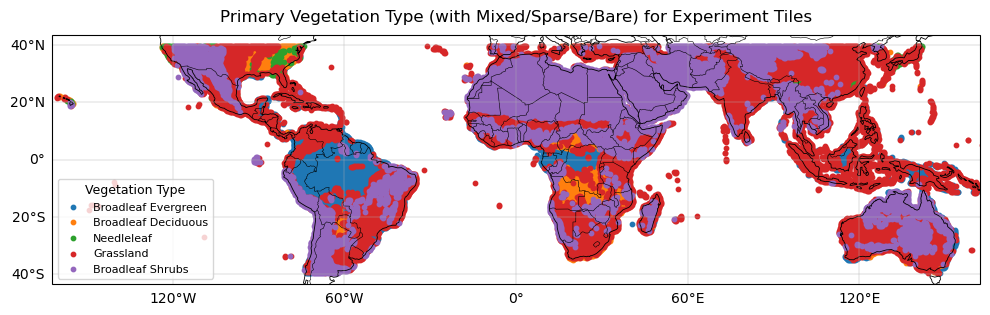

In [31]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

lat = np.asarray(com_lat)
lon = np.asarray(com_lon)

# bring longitudes to [-180, 180]
lon = np.where(lon > 180.0, lon - 360.0, lon)

# ---- labels for legend (codes from your mosaic definition + mixed/sparse/bare) ----
label_map = {
    0: "Bare",
    1: "Broadleaf Evergreen",
    2: "Broadleaf Deciduous",
    3: "Needleleaf",
    4: "Grassland",
    5: "Broadleaf Shrubs",
    6: "Dwarf Trees",
    7: "Mixed",
    8: "Sparse",
}

# only plot classes that appear
classes_present = np.unique(veg_type_out[np.isfinite(veg_type_out)])

# ---- figure ----
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=proj)

# set extent with small padding
lat_min, lat_max = np.nanmin(lat), np.nanmax(lat)
lon_min, lon_max = np.nanmin(lon), np.nanmax(lon)
dlat = max(2.0, 0.05 * (lat_max - lat_min + 1e-6))
dlon = max(2.0, 0.05 * (lon_max - lon_min + 1e-6))
ax.set_extent([lon_min - dlon, lon_max + dlon, lat_min - dlat, lat_max + dlat], crs=proj)

# map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3)
gl.top_labels = False
gl.right_labels = False

# plot each class as its own scatter (lets Matplotlib assign distinct default colors)
handles = []
labels = []
for code in classes_present:
    mask = veg_type_out == code
    if not np.any(mask):
        continue
    sc = ax.scatter(lon[mask], lat[mask], s=10, transform=proj, label=label_map.get(int(code), f"Class {int(code)}"))
    handles.append(sc)
    labels.append(label_map.get(int(code), f"Class {int(code)}"))

# legend
leg = ax.legend(handles, labels, title="Vegetation Type", loc="lower left", frameon=True, fontsize=8, title_fontsize=9)

ax.set_title("Primary Vegetation Type (with Mixed/Sparse/Bare) for Experiment Tiles", fontsize=12, pad=10)
plt.tight_layout()

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/4133699461.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


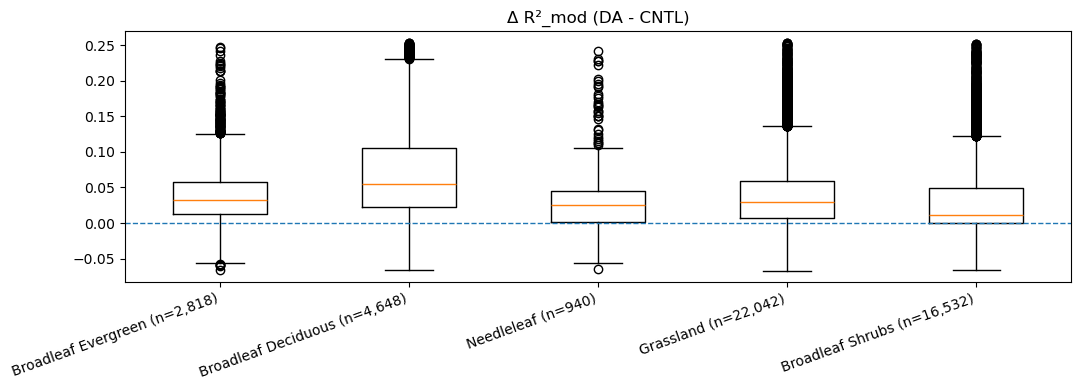

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/4133699461.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


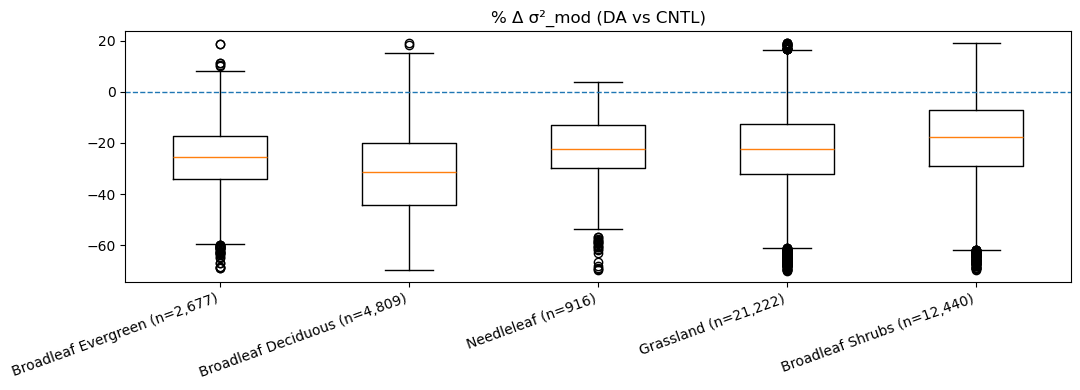

In [32]:
import matplotlib.pyplot as plt

def box_by_veg(y, yname):
    label_map = {
        0: "Bare", 1: "Broadleaf Evergreen", 2: "Broadleaf Deciduous",
        3: "Needleleaf", 4: "Grassland", 5: "Broadleaf Shrubs",
        6: "Dwarf Trees", 7: "Mixed", 8: "Sparse",
    }
    order = [1,2,3,4,5,6,7,8,0]  # tweak if you like
    data, labels = [], []
    for k in order:
        sel = np.isfinite(veg_type_out) & (veg_type_out == k) & np.isfinite(y)
        if sel.any():
            data.append(y[sel])
            labels.append(f"{label_map[k]} (n={sel.sum():,})")
    plt.figure(figsize=(11,4))
    plt.boxplot(data, labels=labels, showfliers=True)
    plt.axhline(0, ls="--", lw=1)
    plt.title(yname)
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

box_by_veg(target_dR2, target_dR2_name)
box_by_veg(target_pct_sig2, target_pct_sig2_name)


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3790786127.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = (df.groupby("bin")[t_name]
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3790786127.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=xlabels, showfliers=True)



=== Δ R²_mod (DA - CNTL) by Mean Annual LAI (m2/m2) fixed bins (5) ===
           count    median      mean       std       q25       q75
bin                                                               
0–0.10     10473  0.000386  0.019018  0.039752  0.000000  0.030285
0.10–0.50  10807  0.017741  0.027780  0.037934  0.000220  0.046903
0.50–1.30  11404  0.041039  0.050072  0.047181  0.016458  0.073468
1.30–2.60  10500  0.042242  0.054326  0.051234  0.018946  0.077935
>2.60       3724  0.029273  0.036655  0.044205  0.007265  0.056524


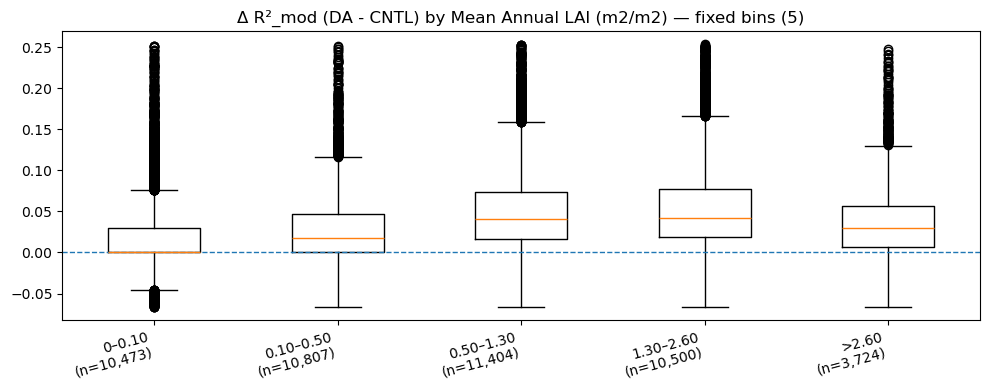


=== % Δ σ²_mod (DA vs CNTL) by Mean Annual LAI (m2/m2) fixed bins (5) ===
           count     median       mean        std        q25        q75
bin                                                                    
0–0.10      6664 -12.816806 -14.687395  13.524358 -22.772332  -4.326508
0.10–0.50   9860 -17.400815 -18.265215  14.827168 -28.109599  -5.940006
0.50–1.30  11397 -25.947676 -26.159586  14.773032 -35.489068 -16.599996
1.30–2.60  10571 -26.827975 -28.368434  14.685352 -37.692274 -17.753909
>2.60       3513 -23.874989 -24.892063  13.704481 -33.016360 -15.459397


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3790786127.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = (df.groupby("bin")[t_name]
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3790786127.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=xlabels, showfliers=True)


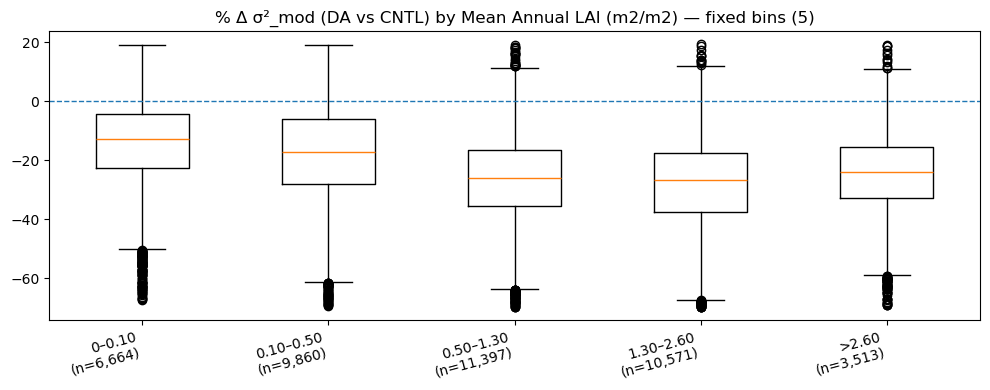

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3790786127.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = (df.groupby("bin")[t_name]
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3790786127.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=xlabels, showfliers=True)



=== Δ R²_mod (DA - CNTL) by Mean Annual Greenness quantile bins (q=5) ===
                count    median      mean       std       q25       q75
bin                                                                    
(0.294, 0.752]  10265  0.000762  0.018664  0.038779  0.000000  0.030634
(0.752, 0.874]  11814  0.024213  0.034580  0.043033  0.000537  0.056368
(0.874, 0.918]  11424  0.038388  0.049725  0.050292  0.013897  0.073247
(0.918, 0.945]   8937  0.038993  0.048971  0.049040  0.015682  0.072251
(0.945, 0.983]   3978  0.034350  0.040863  0.039779  0.015356  0.058978


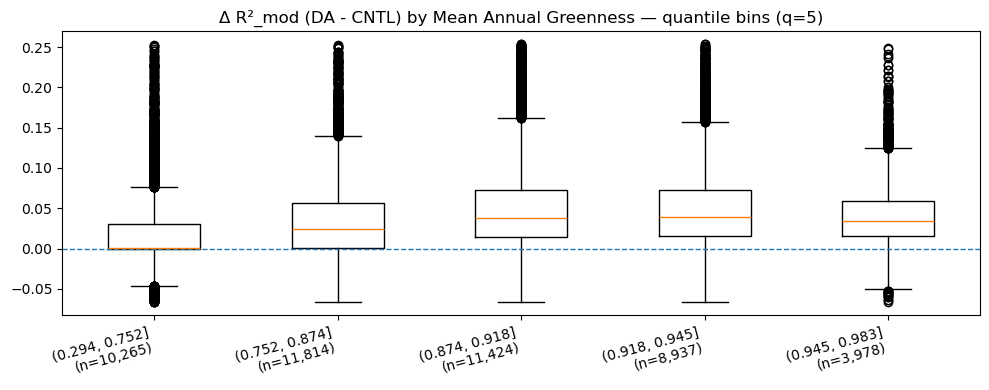

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3790786127.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = (df.groupby("bin")[t_name]
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3790786127.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=xlabels, showfliers=True)



=== % Δ σ²_mod (DA vs CNTL) by Mean Annual Greenness quantile bins (q=5) ===
                count     median       mean        std        q25        q75
bin                                                                         
(0.294, 0.752]   6751 -12.504138 -14.246111  13.363850 -22.263414  -3.651678
(0.752, 0.874]  10713 -19.769694 -20.124236  14.815747 -29.655569  -8.636375
(0.874, 0.918]  11407 -25.835485 -26.445559  15.471761 -36.297079 -15.806754
(0.918, 0.945]   8855 -26.715868 -27.611700  14.511224 -36.664729 -17.436696
(0.945, 0.983]   3885 -24.911795 -26.120727  13.272213 -34.287778 -16.751301


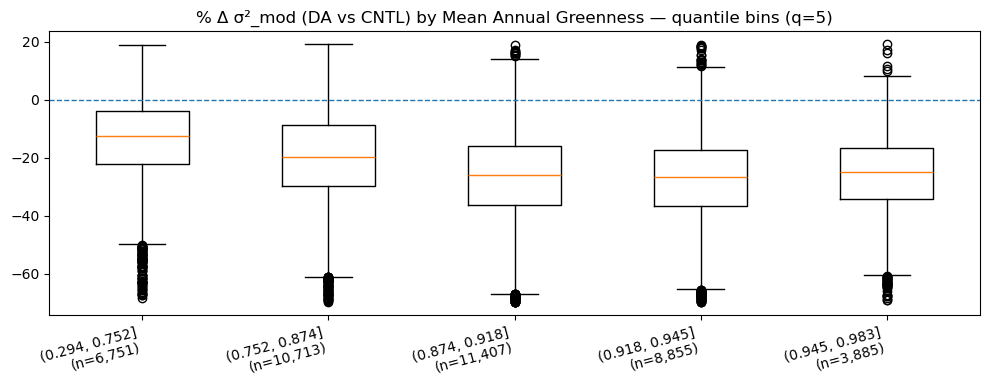

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3790786127.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = (df.groupby("bin")[t_name]
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3790786127.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=xlabels, showfliers=True)



=== Δ R²_mod (DA - CNTL) by Aridity Index (P/PET) quantile bins (q=5) ===
                  count    median      mean       std       q25       q75
bin                                                                      
(0.00232, 0.116]  10722  0.004867  0.020192  0.039115  0.000000  0.031553
(0.116, 0.341]    11491  0.027807  0.036748  0.046158  0.000930  0.058774
(0.341, 0.694]    10518  0.044227  0.052991  0.051176  0.013969  0.079720
(0.694, 1.217]     9224  0.038480  0.048316  0.047212  0.014578  0.071724
(1.217, 2.727]     4518  0.025196  0.030106  0.032286  0.009387  0.043921


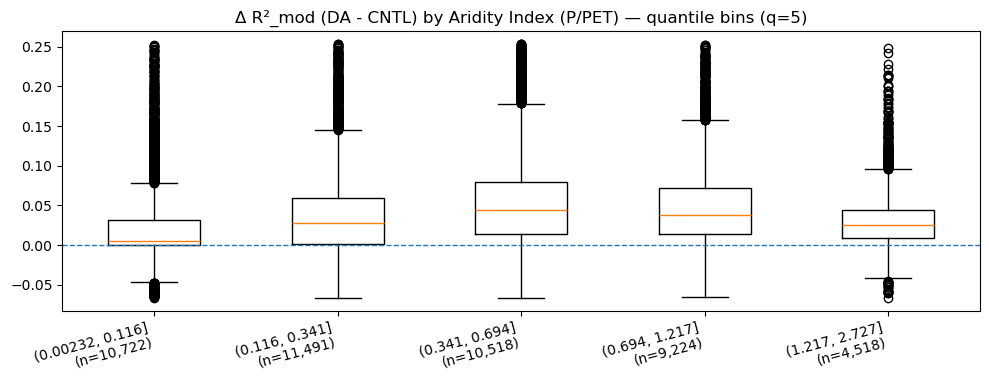

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3790786127.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = (df.groupby("bin")[t_name]
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_52247/3790786127.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=xlabels, showfliers=True)



=== % Δ σ²_mod (DA vs CNTL) by Aridity Index (P/PET) quantile bins (q=5) ===
                  count     median       mean        std        q25        q75
bin                                                                           
(0.00232, 0.116]   7186 -13.440332 -15.091962  12.478277 -21.912960  -6.754190
(0.116, 0.341]    10648 -22.266443 -22.379501  15.715952 -32.484100 -10.582989
(0.341, 0.694]    10560 -27.068876 -27.467236  16.314638 -38.085623 -16.848875
(0.694, 1.217]     9134 -25.568865 -25.890209  14.484957 -35.506375 -15.944679
(1.217, 2.727]     4282 -20.201353 -20.910962  11.982749 -28.045810 -13.198326


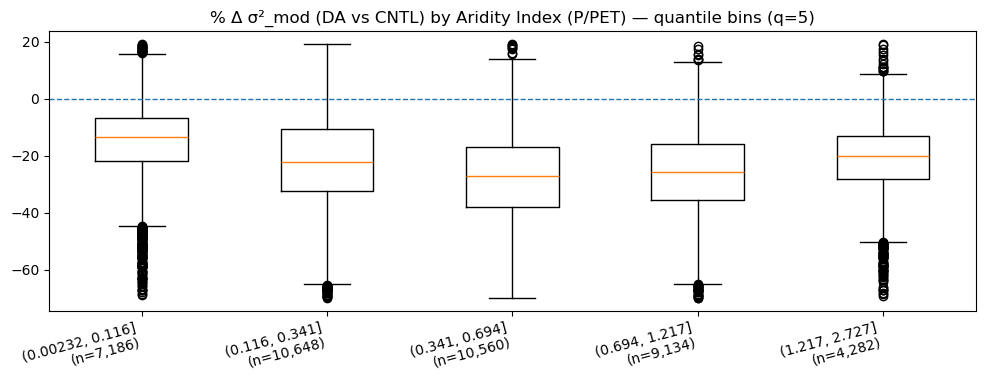

In [33]:
# Inputs assumed to exist:
#   pred_ai, pred_ai_name
#   pred_mean_lai, pred_mean_lai_name
#   pred_mean_greeness, pred_mean_greeness_name
#   target_dR2, target_dR2_name
#   target_pct_sig2, target_pct_sig2_name

def bin_and_plot(predictor, predictor_name, targets, q=5, dropna=True,
                 bins=None, labels=None, include_lowest=True, right=True):
    """
    Bin a predictor and plot target distributions per bin.

    If `bins` is provided (list-like), uses fixed bins via pd.cut.
    Otherwise, uses quantile bins via pd.qcut with q quantiles.

    targets = list of (target_array, target_name) tuples.
    """
    # assemble DataFrame
    df = pd.DataFrame({predictor_name: predictor})
    for t_arr, t_name in targets:
        df[t_name] = t_arr

    # clean NaNs/infs
    df = df.replace([np.inf, -np.inf], np.nan)
    if dropna:
        df = df.dropna(subset=[predictor_name])
    if df.empty:
        print(f"{predictor_name}: no valid rows after dropna.")
        return

    # choose binning method
    if bins is not None:
        # fixed bins
        df["bin"] = pd.cut(df[predictor_name], bins=bins, labels=labels,
                           include_lowest=include_lowest, right=right)
        bin_order = df["bin"].cat.categories
        bin_desc = f"fixed bins ({len(bin_order)})"
    else:
        # quantile bins; reduce q if duplicates happen
        q_use = q
        while True:
            try:
                df["bin"] = pd.qcut(df[predictor_name], q=q_use, duplicates="drop")
                break
            except ValueError:
                q_use -= 1
                if q_use < 2:
                    df["bin"] = pd.cut(df[predictor_name], bins=1)
                    break
        bin_order = df["bin"].cat.categories
        bin_desc = f"quantile bins (q={q_use})"

    # per-target plots and summaries
    for t_arr, t_name in targets:
        desc = (df.groupby("bin")[t_name]
                  .agg(count="count",
                       median=lambda x: np.nanmedian(x),
                       mean="mean",
                       std="std",
                       q25=lambda x: np.nanpercentile(x, 25),
                       q75=lambda x: np.nanpercentile(x, 75)))
        print(f"\n=== {t_name} by {predictor_name} {bin_desc} ===")
        print(desc)

        # prepare boxplot data & labels
        data, xlabels = [], []
        for b in bin_order:
            vals = df.loc[df["bin"] == b, t_name].dropna().values
            data.append(vals)
            xlabels.append(f"{b}\n(n={len(vals):,})")

        # plot
        plt.figure(figsize=(10, 4))
        plt.boxplot(data, labels=xlabels, showfliers=True)
        plt.axhline(0.0, ls="--", lw=1)
        plt.title(f"{t_name} by {predictor_name} — {bin_desc}")
        plt.xticks(rotation=15, ha="right")
        plt.tight_layout()
        plt.show()
     


targets_list = [
    (target_dR2, target_dR2_name),
    (target_pct_sig2, target_pct_sig2_name),
]

# 1) LAI with *fixed* bins (rounded, physically meaningful)
lai_bins   = [0.0, 0.10, 0.50, 1.30, 2.60, np.inf]
lai_labels = ["0–0.10", "0.10–0.50", "0.50–1.30", "1.30–2.60", ">2.60"]
bin_and_plot(pred_mean_lai, pred_mean_lai_name, targets_list,
             bins=lai_bins, labels=lai_labels)

# 2) Greenness with quantiles (unchanged)
bin_and_plot(pred_mean_greeness, pred_mean_greeness_name, targets_list, q=5)

# 3) Aridity Index with quantiles (unchanged) or supply your own thresholds
bin_and_plot(pred_ai, pred_ai_name, targets_list, q=5)
# e.g., fixed AI bins:
# ai_bins   = [0, 0.2, 0.5, 1.0, 2.0, np.inf]
# ai_labels = ["≤0.2","0.2–0.5","0.5–1.0","1.0–2.0",">2.0"]
# bin_and_plot(pred_ai, pred_ai_name, targets_list, bins=ai_bins, labels=ai_labels)